1. Cleveland Dataset Analysis:

Cleveland Dataset Basic Information:
Number of records: 303
Number of features: 14

First 5 rows:
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  target  
0    3.0  0.0   6.0       0  
1    2.0  3.0   3.0       2  
2    2.0  2.0   7.0       1  
3    3.0  0.0   3.0       0  
4    1.0  0.0   3.0       0  

Missing values per column:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64

Descriptive Statistic

<Figure size 1500x1000 with 0 Axes>

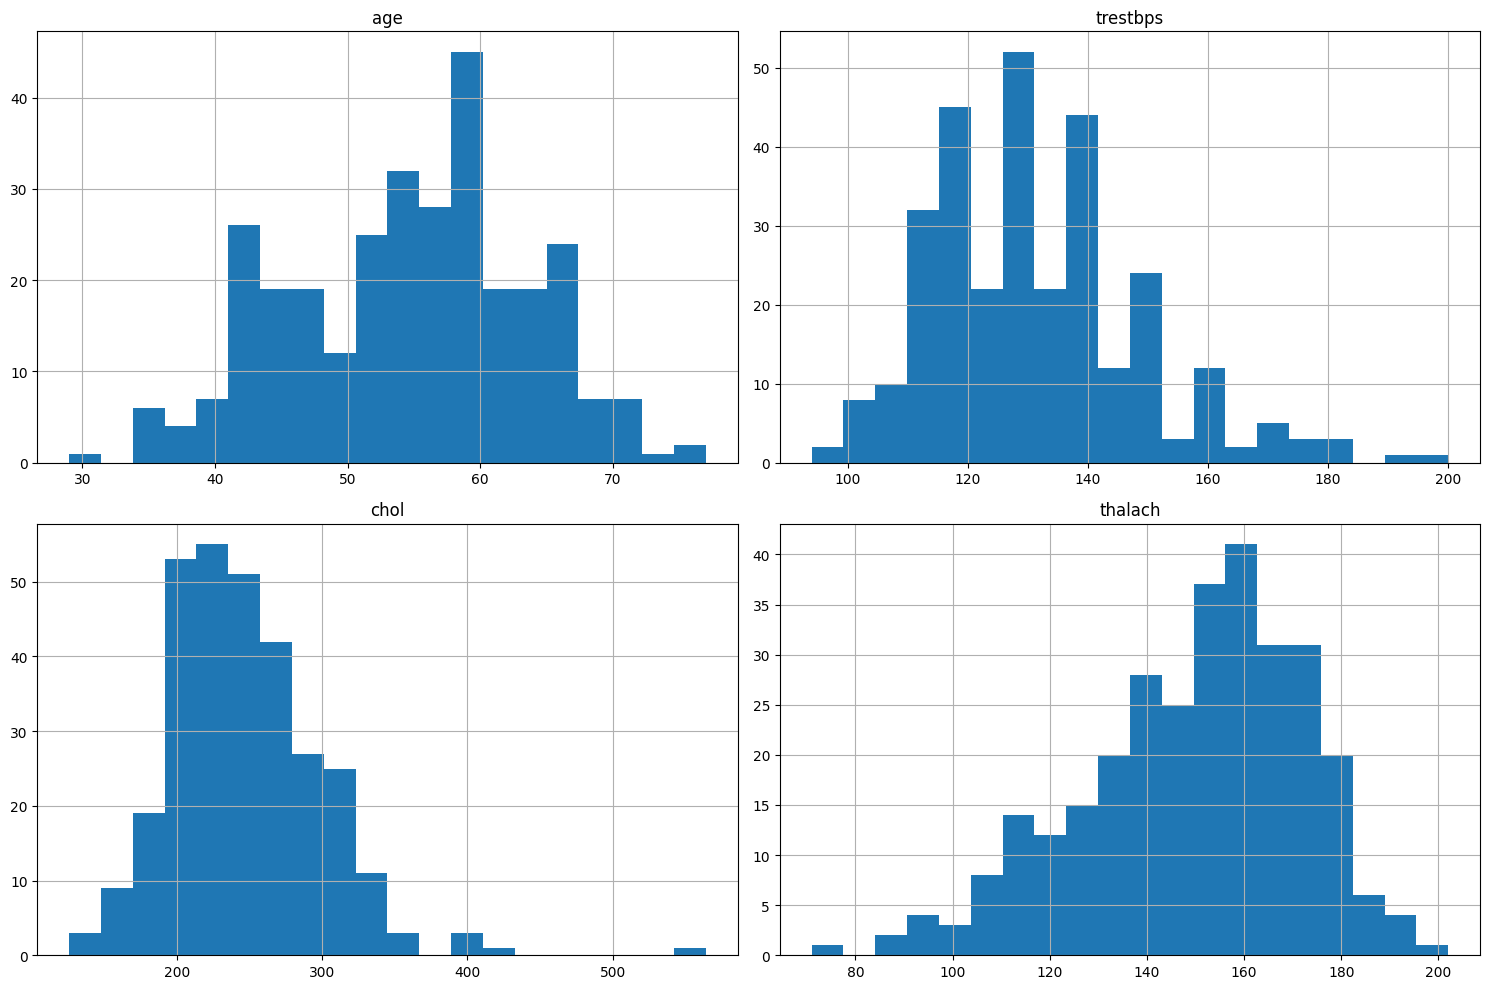

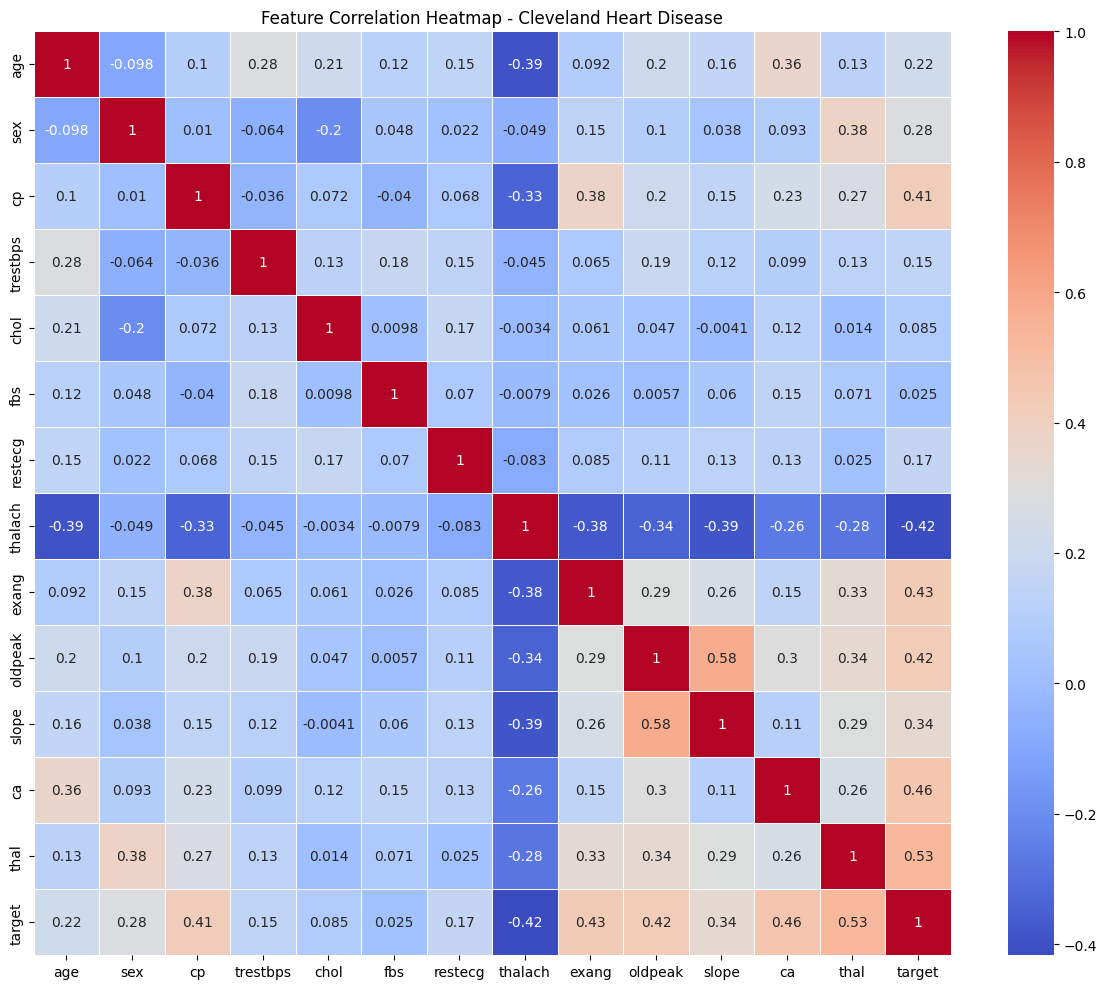

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

#cleveland dataset path
cleveland_path = '/Users/andrechu/Desktop/UnivUtah/BMI6106/Project/heart+disease/processed.cleveland.data'

#column names for the Cleveland dataset (based on documentation)
column_names = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
    'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'
]

#load cleveland dataset
try:
    #ensure csv format is properly read
    cleveland_df = pd.read_csv(cleveland_path, names=column_names, na_values='?')
except:
    try:
        #if that fails, try space-separated format
        cleveland_df = pd.read_csv(cleveland_path, names=column_names, delim_whitespace=True, na_values='?')
    except Exception as e:
        #error message create dummy df for temp testing
        print(f"Error loading Cleveland dataset: {e}")
        cleveland_df = pd.DataFrame(columns=column_names)

#visualize basic dataset information
print("Cleveland Dataset Basic Information:")
print(f"Number of records: {len(cleveland_df)}")
print(f"Number of features: {len(cleveland_df.columns)}")
print("\nFirst 5 rows:")
print(cleveland_df.head())

#check for missing values
print("\nMissing values per column:")
print(cleveland_df.isnull().sum())

#convert target to binary 
if not cleveland_df.empty:
    #if target has values > 1, convert to binary (0 = no disease, 1 = disease)
    if cleveland_df['target'].max() > 1:
        cleveland_df['target'] = cleveland_df['target'].apply(lambda x: 1 if x > 0 else 0)
    
    #print descriptive stats of the dataset
    print("\nDescriptive Statistics:")
    print(cleveland_df.describe())
    
    #check target variable distribution
    print("\nTarget Variable Distribution:")
    target_counts = cleveland_df['target'].value_counts()
    print(target_counts)
    print(f"Percentage with heart disease: {target_counts[1] / len(cleveland_df) * 100:.2f}%")
    
    #analyze correlations between features and target
    print("\nCorrelations with Target Variable:")
    correlations = cleveland_df.corr()['target'].sort_values(ascending=False)
    print(correlations)
    
    #save important variables for cross-dataset validation
    key_features = ['age', 'sex', 'trestbps', 'chol', 'thalach', 'target']
    cleveland_key_df = cleveland_df[key_features]
    print("\nKey features for cross-dataset validation:")
    print(cleveland_key_df.head())
    
    #visualizations for key features
    print("\nGenerating visualizations")
    
    #histograms of numerical features
    plt.figure(figsize=(15, 10))
    cleveland_df[['age', 'trestbps', 'chol', 'thalach']].hist(bins=20, figsize=(15, 10))
    plt.tight_layout()
    plt.savefig('cleveland_histograms.png')
    
    #correlation heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(cleveland_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Feature Correlation Heatmap - Cleveland Heart Disease')
    plt.tight_layout()
    plt.savefig('cleveland_correlation.png')
    
    print("Visualizations saved.")
else:
    print("No data available for visualizations.")

print("\nCleveland dataset analysis complete.")

2. MIMIC-IV Dataset Analysis:

In [5]:
import pandas as pd
import numpy as np
import json
import gzip
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

#base path to the MIMIC-IV FHIR dataset
mimic_base_path = '/Users/andrechu/Desktop/UnivUtah/BMI6106/Project/MIMIC-IV/physionet.org/files/mimic-iv-fhir/2.1/fhir/'

#file paths for key MIMIC-IV files
patient_file = os.path.join(mimic_base_path, 'MimicPatient.ndjson.gz')
condition_file = os.path.join(mimic_base_path, 'MimicCondition.ndjson.gz')
vitals_file = os.path.join(mimic_base_path, 'MimicObservationVitalSignsED.ndjson.gz')
lab_file = os.path.join(mimic_base_path, 'MimicObservationLabevents.ndjson.gz')
encounter_file = os.path.join(mimic_base_path, 'MimicEncounter.ndjson.gz')

#reads the first n lines from a gzipped ndjson file
def read_ndjson_sample(file_path, n=10):
    data = []
    try:
        with gzip.open(file_path, 'rt') as file:
            for i, line in enumerate(file):
                if i >= n:
                    break
                data.append(json.loads(line))
        return data
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return []

#extracts patient demographics
def extract_patient_data(patients_data, n=1000):
    current_year = 2025  
    
    patient_records = []
    for patient in patients_data[:n]:
        try:
            #extract patient ID
            patient_id = patient.get('id', '')
            
            #extract birth date and calculate age
            birth_date = patient.get('birthDate', '')
            age = None
            if birth_date:
                try:
                    birth_year = int(birth_date.split('-')[0])
                    age = current_year - birth_year
                except:
                    pass
            
            #extract gender
            gender = patient.get('gender', '')
            
            #extract race/ethnicity if available
            race = None
            if 'extension' in patient:
                for ext in patient['extension']:
                    if ext.get('url', '').endswith('patient-race'):
                        race = ext.get('valueString', '')
                        break
            
            patient_records.append({
                'patient_id': patient_id,
                'age': age,
                'gender': gender,
                'race': race
            })
        except Exception as e:
            print(f"Error processing patient: {e}")
    
    return pd.DataFrame(patient_records)

#function to identify CVD patients based on condition codes
def extract_condition_data(conditions_data, n=1000):
    #ICD-10 codes for CVD
    cvd_codes = ['I10', 'I20', 'I21', 'I50', 'I25']
    
    condition_records = []
    for condition in conditions_data[:n]:
        try:
            #extract patient ID
            patient_id = condition.get('subject', {}).get('reference', '').replace('Patient/', '')
            
            #extract condition code
            code = None
            coding = condition.get('code', {}).get('coding', [])
            for code_entry in coding:
                if code_entry.get('system', '').endswith('icd10cm'):
                    code = code_entry.get('code', '')
                    break
            
            #check if this is a CVD condition
            is_cvd = any(code.startswith(cvd_code) for cvd_code in cvd_codes) if code else False
            
            #extract category (encounter diagnosis vs. chronic)
            category = None
            if 'category' in condition:
                for cat in condition['category']:
                    if 'coding' in cat:
                        for cat_code in cat['coding']:
                            category = cat_code.get('code', '')
                            break
            
            condition_records.append({
                'patient_id': patient_id,
                'code': code,
                'is_cvd': is_cvd,
                'category': category
            })
        except Exception as e:
            print(f"Error processing condition: {e}")
    
    return pd.DataFrame(condition_records)

#extract vital signs (blood pressure and heart rate)
def extract_vitals_data(vitals_data, n=1000):
    vitals_records = []
    for vital in vitals_data[:n]:
        try:
            #extract patient ID
            patient_id = vital.get('subject', {}).get('reference', '').replace('Patient/', '')
            
            #extract observation code and value
            code = None
            value = None
            
            #get the observation code
            coding = vital.get('code', {}).get('coding', [])
            for code_entry in coding:
                code = code_entry.get('code', '')
                break
            
            #get the value based on the observation type
            if 'valueQuantity' in vital:
                value = vital['valueQuantity'].get('value', None)
            
            #extract date/time
            effective_datetime = vital.get('effectiveDateTime', '')
            
            #identify BP and HR observations
            
            #common for these measurements in MIMIC
            
            #systolic BP
            is_sbp = code in ['8480-6', '8462-4']  
            #diastolic BP
            is_dbp = code in ['8462-4', '8478-0']  
            #heart rate
            is_hr = code in ['8867-4', '8898-9']   
            
            vitals_records.append({
                'patient_id': patient_id,
                'code': code,
                'value': value,
                'datetime': effective_datetime,
                'is_sbp': is_sbp,
                'is_dbp': is_dbp,
                'is_hr': is_hr
            })
        except Exception as e:
            print(f"Error processing vital sign: {e}")
    
    return pd.DataFrame(vitals_records)

#extract lab events for patient cholesterol
def extract_lab_data(lab_data, n=1000):
    lab_records = []
    
    #common LOINC codes for cholesterol measurements
    chol_codes = ['2093-3', '13457-7', '2085-9', '14815-5']
    
    for lab in lab_data[:n]:
        try:
            #extract patient ID
            patient_id = lab.get('subject', {}).get('reference', '').replace('Patient/', '')
            
            #extract lab code and value
            code = None
            value = None
            
            #get the lab code
            coding = lab.get('code', {}).get('coding', [])
            for code_entry in coding:
                code = code_entry.get('code', '')
                break

            #obtain value
            if 'valueQuantity' in lab:
                value = lab['valueQuantity'].get('value', None)
            
            #extract date/time
            effective_datetime = lab.get('effectiveDateTime', '')
            
            #check to verify chol measurement
            is_cholesterol = code in chol_codes
            
            lab_records.append({
                'patient_id': patient_id,
                'code': code,
                'value': value,
                'datetime': effective_datetime,
                'is_cholesterol': is_cholesterol
            })
        except Exception as e:
            print(f"Error processing lab event: {e}")
    
    return pd.DataFrame(lab_records)

#function to extract encounter data
def extract_encounter_data(encounter_data, n=1000):
    """Extract hospital encounter information."""
    encounter_records = []
    for encounter in encounter_data[:n]:
        try:
            #get encounter ID and patient ID
            encounter_id = encounter.get('id', '')
            patient_id = encounter.get('subject', {}).get('reference', '').replace('Patient/', '')
            
            #extract encounter type
            encounter_type = None
            if 'type' in encounter:
                for typ in encounter['type']:
                    if 'coding' in typ:
                        for type_code in typ['coding']:
                            encounter_type = type_code.get('code', '')
                            break
            
            #extract length of stay
            length_of_stay = None
            if 'length' in encounter:
                length_of_stay = encounter['length']
            
            #extract discharge status
            discharge_status = None
            if 'hospitalization' in encounter and 'dischargeDisposition' in encounter['hospitalization']:
                for disp in encounter['hospitalization']['dischargeDisposition']['coding']:
                    discharge_status = disp.get('code', '')
                    break
            
            encounter_records.append({
                'encounter_id': encounter_id,
                'patient_id': patient_id,
                'encounter_type': encounter_type,
                'length_of_stay': length_of_stay,
                'discharge_status': discharge_status
            })
        except Exception as e:
            print(f"Error processing encounter: {e}")
    
    return pd.DataFrame(encounter_records)

#main analysis of MIMIC-IV dataset
def analyze_mimic_data(sample_size=1000):
    """Analyze samples from MIMIC-IV dataset files."""
    print("MIMIC-IV Dataset Analysis")
    print("========================\n")
    
    #sample data from each file
    print(f"Reading sample data (n={sample_size}) from MIMIC-IV files...")
    patient_data = read_ndjson_sample(patient_file, sample_size)
    condition_data = read_ndjson_sample(condition_file, sample_size)
    vitals_data = read_ndjson_sample(vitals_file, sample_size)
    lab_data = read_ndjson_sample(lab_file, sample_size)
    encounter_data = read_ndjson_sample(encounter_file, sample_size)
    
    #process each data type
    print("\nExtracting patient demographics...")
    patients_df = extract_patient_data(patient_data, sample_size)
    print(f"Extracted demographics for {len(patients_df)} patients")
    
    print("\nExtracting condition data...")
    conditions_df = extract_condition_data(condition_data, sample_size)
    print(f"Extracted {len(conditions_df)} conditions")
    
    print("\nExtracting vital signs data...")
    vitals_df = extract_vitals_data(vitals_data, sample_size)
    print(f"Extracted {len(vitals_df)} vital sign measurements")
    
    print("\nExtracting lab data...")
    lab_df = extract_lab_data(lab_data, sample_size)
    print(f"Extracted {len(lab_df)} lab measurements")
    
    print("\nExtracting encounter data...")
    encounter_df = extract_encounter_data(encounter_data, sample_size)
    print(f"Extracted {len(encounter_df)} hospital encounters")
    
    #basic statistics on patient demographics
    print("\nPatient Demographics Summary:")
    print(patients_df.describe(include='all'))
    
    #gender distribution
    if not patients_df.empty:
        print("\nGender Distribution:")
        print(patients_df['gender'].value_counts())
    
    #age distribution
    if 'age' in patients_df.columns:
        print("\nAge Distribution:")
        print(patients_df['age'].describe())
    
    #CVD prevalence
    if not conditions_df.empty:
        print("\nCVD Prevalence:")
        cvd_count = conditions_df['is_cvd'].sum()
        print(f"Number of CVD conditions: {cvd_count}")
        print(f"Percentage of conditions that are CVD: {cvd_count / len(conditions_df) * 100:.2f}%")
        
        #number of unique patients with CVD
        cvd_patients = conditions_df[conditions_df['is_cvd']]['patient_id'].nunique()
        total_patients = conditions_df['patient_id'].nunique()
        print(f"Number of unique patients with CVD: {cvd_patients} out of {total_patients} ({cvd_patients / total_patients * 100:.2f}%)")
    
    #vital signs statistics
    if not vitals_df.empty:
        print("\nVital Signs Summary:")
        sbp_df = vitals_df[vitals_df['is_sbp']]
        dbp_df = vitals_df[vitals_df['is_dbp']]
        hr_df = vitals_df[vitals_df['is_hr']]
        
        print(f"Number of systolic BP measurements: {len(sbp_df)}")
        if not sbp_df.empty:
            print("Systolic BP statistics:")
            print(sbp_df['value'].describe())
        
        print(f"Number of diastolic BP measurements: {len(dbp_df)}")
        if not dbp_df.empty:
            print("Diastolic BP statistics:")
            print(dbp_df['value'].describe())
        
        print(f"Number of heart rate measurements: {len(hr_df)}")
        if not hr_df.empty:
            print("Heart rate statistics:")
            print(hr_df['value'].describe())
    
    #cholesterol measurements
    if not lab_df.empty:
        chol_df = lab_df[lab_df['is_cholesterol']]
        print(f"\nNumber of cholesterol measurements: {len(chol_df)}")
        if not chol_df.empty:
            print("Cholesterol statistics:")
            print(chol_df['value'].describe())
    
    #hospital encounter information
    if not encounter_df.empty:
        print("\nHospital Encounter Summary:")
        if 'length_of_stay' in encounter_df.columns:
            print("Length of stay (hours) statistics:")
            print(encounter_df['length_of_stay'].describe())
        
        if 'encounter_type' in encounter_df.columns:
            print("\nEncounter types:")
            print(encounter_df['encounter_type'].value_counts())
        
        if 'discharge_status' in encounter_df.columns:
            print("\nDischarge status:")
            print(encounter_df['discharge_status'].value_counts())
    
    #return processed dataframes for further analysis
    return {
        'patients': patients_df,
        'conditions': conditions_df,
        'vitals': vitals_df,
        'labs': lab_df,
        'encounters': encounter_df
    }

#run the analysis
if __name__ == "__main__":
    print("Beginning MIMIC-IV analysis...")
    #just analyze on a set n samples
    mimic_data = analyze_mimic_data(1000)  
    print("\nMIMIC-IV analysis complete.")

Beginning MIMIC-IV analysis...
MIMIC-IV Dataset Analysis

Reading sample data (n=1000) from MIMIC-IV files...

Extracting patient demographics...
Extracted demographics for 1000 patients

Extracting condition data...
Extracted 1000 conditions

Extracting vital signs data...
Extracted 1000 vital sign measurements

Extracting lab data...
Extracted 1000 lab measurements

Extracting encounter data...
Extracted 1000 hospital encounters

Patient Demographics Summary:
                                  patient_id          age  gender race
count                                   1000  1000.000000    1000    0
unique                                  1000          NaN       2    0
top     0a8eebfd-a352-522e-89f0-1d4a13abdebc          NaN  female  NaN
freq                                       1          NaN     527  NaN
mean                                     NaN   -79.445000     NaN  NaN
std                                      NaN    30.700969     NaN  NaN
min                                  

3. Specifically Analyze CVD Patients in the MIMIC-IV Dataset:

Analyzing MIMIC-IV condition data for CVD patients...
Looking for ICD-10 codes: I10, I20, I21, I25, I50
Processed 10000 records...
Processed 20000 records...
Processed 30000 records...
Processed 40000 records...
Processed 50000 records...
Processed 60000 records...
Processed 70000 records...
Processed 80000 records...
Processed 90000 records...

===== CVD Patient Analysis Summary =====
Total condition records processed: 100000
CVD condition records identified: 3520 (3.52%)
Unique patients with CVD conditions: 951

Top 10 CVD condition codes:
  I10: 1119 occurrences
  I2510: 493 occurrences
  I4891: 300 occurrences
  I252: 191 occurrences
  I110: 173 occurrences
  I480: 139 occurrences
  I5032: 101 occurrences
  I5022: 96 occurrences
  I5033: 83 occurrences
  I5023: 64 occurrences

Distribution of CVD types among patients:
  I10: 663 patients (69.72%)
  I20: 5 patients (0.53%)
  I21: 97 patients (10.20%)
  I25: 324 patients (34.07%)
  I50: 243 patients (25.55%)
Saved data for 951 CVD pa

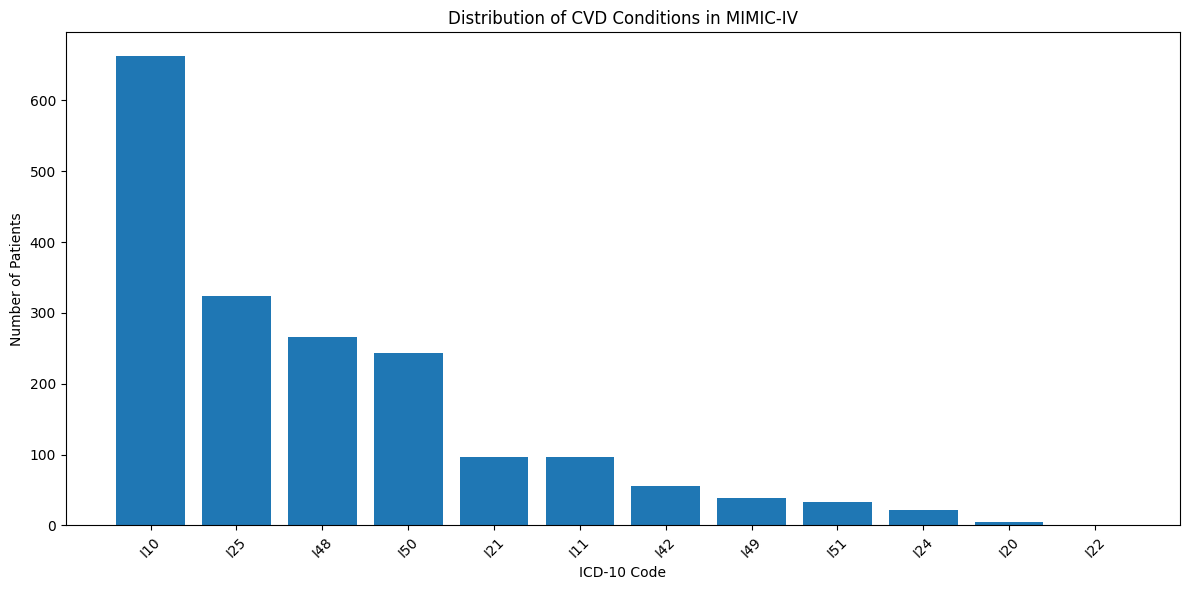

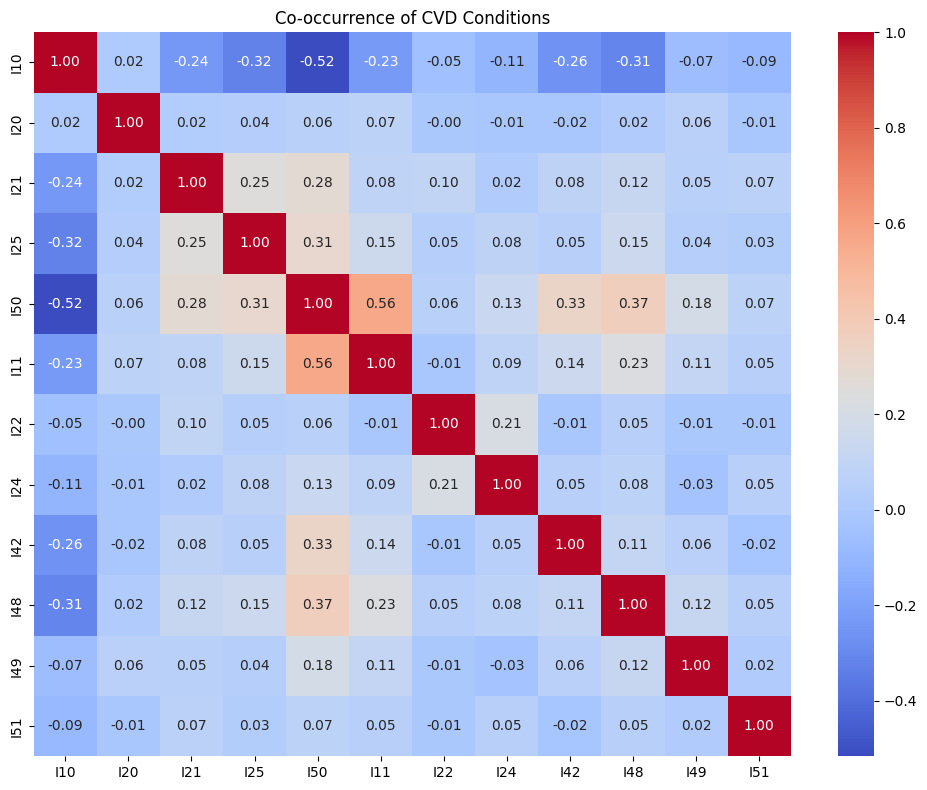

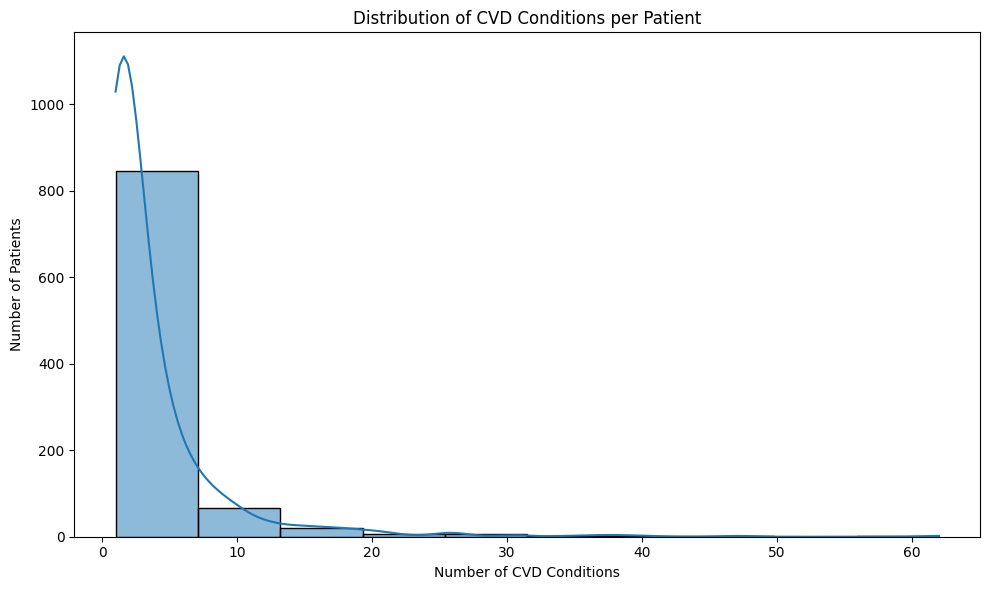

In [6]:
import json
import gzip
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

#MIMIC-IV condition file
condition_file = '/Users/andrechu/Desktop/UnivUtah/BMI6106/Project/MIMIC-IV/physionet.org/files/mimic-iv-fhir/2.1/fhir/MimicCondition.ndjson.gz'

#define ICD-10 codes for cardiovascular diseases 
CVD_CODES = [
    'I10',   #essential (primary) hypertension
    'I20',   #angina pectoris
    'I21',   #acute myocardial infarction
    'I25',   #chronic ischemic heart disease
    'I50'    #heart failure
]

#include other common CVD codes for a more comprehensive analysis
ADDITIONAL_CVD_CODES = [
    'I11',   #hypertensive heart disease
    'I22',   #subsequent myocardial infarction
    'I24',   #other acute ischemic heart diseases
    'I42',   #cardiomyopathy
    'I48',   #atrial fibrillation and flutter
    'I49',   #other cardiac arrhythmias
    'I51'    #complications and ill-defined descriptions of heart disease
]

ALL_CVD_CODES = CVD_CODES + ADDITIONAL_CVD_CODES

#function to analyze CVD in the MIMIC-IV dataset
def analyze_cvd_conditions(max_records=None):
    print(f"Analyzing MIMIC-IV condition data for CVD patients...")
    print(f"Looking for ICD-10 codes: {', '.join(CVD_CODES)}")
    
    #variables to track statistics
    total_records = 0
    cvd_records = 0
    patient_conditions = {}  
    patient_demographics = {}  
    all_codes = []  
    
    #process the gzipped ndjson file
    try:
        with gzip.open(condition_file, 'rt') as file:
            for i, line in enumerate(file):
                if max_records and i >= max_records:
                    break
                
                if i % 10000 == 0 and i > 0:
                    print(f"Processed {i} records...")
                
                total_records += 1
                
                #parse the JSON record
                condition = json.loads(line)
                
                #extract patient ID
                patient_id = None
                if 'subject' in condition and 'reference' in condition['subject']:
                    patient_id = condition['subject']['reference'].replace('Patient/', '')
                
                #skip if we can't identify the patient
                if not patient_id:
                    continue
                
                #extract condition code
                code = None
                code_system = None
                
                if 'code' in condition and 'coding' in condition['code']:
                    for coding in condition['code']['coding']:
                        if 'code' in coding:
                            code = coding['code']
                            code_system = coding.get('system', '')
                            #some codes may be in ICD-9, check for system
                            if 'icd10' in code_system.lower():
                                break
                
                #extract condition name if available
                condition_name = condition.get('code', {}).get('text', 'Unknown')
                
                #skip if no code found
                if not code:
                    continue
                    
                #keep track of all codes for frequency analysis
                all_codes.append(code)
                
                #verify it is a CVD condition
                is_cvd = False
                matched_code = None
                
                #check primary CVD codes first
                for cvd_code in CVD_CODES:
                    if code.startswith(cvd_code):
                        is_cvd = True
                        matched_code = cvd_code
                        break
                
                #check additional CVD codes if not matched yet
                if not is_cvd:
                    for cvd_code in ADDITIONAL_CVD_CODES:
                        if code.startswith(cvd_code):
                            is_cvd = True
                            matched_code = cvd_code
                            break
                
                #if it's a CVD condition, update stats
                if is_cvd:
                    cvd_records += 1
                    
                    #add to patient conditions
                    if patient_id not in patient_conditions:
                        patient_conditions[patient_id] = []
                    
                    patient_conditions[patient_id].append({
                        'code': code,
                        'base_code': matched_code,
                        'name': condition_name,
                        'system': code_system
                    })
                    
                    #extract any demographic info if available
                    if 'subject' in condition and patient_id not in patient_demographics:
                        patient_demographics[patient_id] = {
                            'gender': condition.get('gender', None),
                            'birth_date': condition.get('birthDate', None)
                        }
    
    except Exception as e:
        print(f"Error processing condition file: {e}")
        return None
    
    #compute statistics
    unique_patients = len(patient_conditions)
    code_frequencies = Counter(all_codes)
    cvd_code_frequencies = {code: count for code, count in code_frequencies.items()
                            if any(code.startswith(cvd) for cvd in ALL_CVD_CODES)}
    
    #create a df of CVD patients
    patient_rows = []
    for patient_id, conditions in patient_conditions.items():
        #count occurrences of each base CVD code for this patient
        cvd_counts = Counter([c['base_code'] for c in conditions])
        
        #create a row with counts for each CVD category
        row = {'patient_id': patient_id}
        for code in ALL_CVD_CODES:
            row[f'has_{code}'] = 1 if cvd_counts.get(code, 0) > 0 else 0
            row[f'count_{code}'] = cvd_counts.get(code, 0)
        
        #add total CVD count
        row['total_cvd_conditions'] = len(conditions)
        
        #add demographics if available
        if patient_id in patient_demographics:
            for key, value in patient_demographics[patient_id].items():
                row[key] = value
        
        patient_rows.append(row)
    
    #create DataFrame
    cvd_patients_df = pd.DataFrame(patient_rows)
    
    #output summary statistics
    print("\n===== CVD Patient Analysis Summary =====")
    print(f"Total condition records processed: {total_records}")
    print(f"CVD condition records identified: {cvd_records} ({cvd_records/total_records*100:.2f}%)")
    print(f"Unique patients with CVD conditions: {unique_patients}")
    
    #print code frequencies
    print("\nTop 10 CVD condition codes:")
    for code, count in sorted(cvd_code_frequencies.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  {code}: {count} occurrences")
    
    #print distribution of CVD types
    print("\nDistribution of CVD types among patients:")
    for code in CVD_CODES:
        code_column = f'has_{code}'
        if code_column in cvd_patients_df.columns:
            patient_count = cvd_patients_df[code_column].sum()
            print(f"  {code}: {patient_count} patients ({patient_count/len(cvd_patients_df)*100:.2f}%)")
    
    return cvd_patients_df

def generate_cvd_visualizations(cvd_df):
    if cvd_df is None or len(cvd_df) == 0:
        print("No data available for visualization")
        return
    
    print("\nGenerating visualizations...")
    
    #distribution of CVD conditions
    plt.figure(figsize=(12, 6))
    cvd_counts = []
    
    for code in ALL_CVD_CODES:
        column = f'has_{code}'
        if column in cvd_df.columns:
            count = cvd_df[column].sum()
            cvd_counts.append((code, count))
    
    cvd_counts.sort(key=lambda x: x[1], reverse=True)
    codes, counts = zip(*cvd_counts)
    
    plt.bar(codes, counts)
    plt.title('Distribution of CVD Conditions in MIMIC-IV')
    plt.xlabel('ICD-10 Code')
    plt.ylabel('Number of Patients')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('mimic_cvd_distribution.png')
    
    #co-occurrence of conditions (correlation heatmap)
    plt.figure(figsize=(10, 8))
    
    #select only binary condition columns
    condition_cols = [f'has_{code}' for code in ALL_CVD_CODES if f'has_{code}' in cvd_df.columns]
    
    #calculate correlation
    if len(condition_cols) > 1:
        corr = cvd_df[condition_cols].corr()
        
        #create heatmap
        sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f',
                    xticklabels=[col.replace('has_', '') for col in condition_cols],
                    yticklabels=[col.replace('has_', '') for col in condition_cols])
        plt.title('Co-occurrence of CVD Conditions')
        plt.tight_layout()
        plt.savefig('mimic_cvd_cooccurrence.png')
    
    #distribution of total CVD conditions per patient
    plt.figure(figsize=(10, 6))
    sns.histplot(cvd_df['total_cvd_conditions'], bins=10, kde=True)
    plt.title('Distribution of CVD Conditions per Patient')
    plt.xlabel('Number of CVD Conditions')
    plt.ylabel('Number of Patients')
    plt.tight_layout()
    plt.savefig('mimic_cvd_per_patient.png')
    
    print("Visualizations saved.")

if __name__ == "__main__":
    #can adjust num of records in analysis
    cvd_patients = analyze_cvd_conditions(max_records=100000)
    
    if cvd_patients is not None and len(cvd_patients) > 0:
        #save the data for future use
        cvd_patients.to_csv('mimic_cvd_patients.csv', index=False)
        print(f"Saved data for {len(cvd_patients)} CVD patients to mimic_cvd_patients.csv")
        
        #generate visualizations
        generate_cvd_visualizations(cvd_patients)
        
        #print additional statistics
        print("\nAdditional statistics:")
        print(f"Average number of CVD conditions per patient: {cvd_patients['total_cvd_conditions'].mean():.2f}")
        
        #check how many patients have multiple CVD types
        multiple_cvd_count = (cvd_patients[[f'has_{code}' for code in CVD_CODES if f'has_{code}' in cvd_patients.columns]].sum(axis=1) > 1).sum()
        print(f"Patients with multiple types of CVD: {multiple_cvd_count} ({multiple_cvd_count/len(cvd_patients)*100:.2f}%)")

4. Create MIMIC-IV CVD Cohort for Model Training:

In [7]:
import pandas as pd
import numpy as np
import json
import gzip
import os
from datetime import datetime
from tqdm import tqdm  

#define paths used
mimic_base_path = '/Users/andrechu/Desktop/UnivUtah/BMI6106/Project/MIMIC-IV/physionet.org/files/mimic-iv-fhir/2.1/fhir/'
patient_file = os.path.join(mimic_base_path, 'MimicPatient.ndjson.gz')
condition_file = os.path.join(mimic_base_path, 'MimicCondition.ndjson.gz')
vitals_file = os.path.join(mimic_base_path, 'MimicObservationVitalSignsED.ndjson.gz')
labs_file = os.path.join(mimic_base_path, 'MimicObservationLabevents.ndjson.gz')
chartevents_file = os.path.join(mimic_base_path, 'MimicObservationChartevents.ndjson.gz')

#existing CVD patients file
cvd_patients_file = 'mimic_cvd_patients.csv'

#load the existing CVD patients
def load_cvd_patients():
    print("Loading existing CVD patients file...")
    
    try:
        cvd_df = pd.read_csv(cvd_patients_file)
        print(f"Loaded {len(cvd_df)} CVD patients from existing file")
        
        #ensure patient_id column is present
        if 'patient_id' not in cvd_df.columns:
            print("Error: patient_id column not found in CVD patients file")
            return None
        
        return cvd_df
    
    except Exception as e:
        print(f"Error loading CVD patients file: {e}")
        return None

#function to calculate age correctly from birth date
def calculate_age(birth_date, current_year=2025):
    if not birth_date:
        return None
        
    try:
        birth_year = int(birth_date.split('-')[0])
        
        #handle future birth years
        if birth_year > current_year:
            #for birth years in the future, adjust by subtracting 100 
            birth_year -= 100
            
        age = current_year - birth_year
        
        #cap extreme outlier ages
        if age > 105:
            age = 105
            
        return age
    except:
        return None

#extract patient demographics
def extract_patient_demographics(patient_ids):
    print("Extracting demographics for identified patients...")
    
    patient_demographics = {}
    
    with gzip.open(patient_file, 'rt') as file:
        for line in tqdm(file, desc="Processing patients", unit="records"):
            try:
                patient = json.loads(line)
                patient_id = patient.get('id', '')
                
                #skip if not in our target list
                if patient_id not in patient_ids:
                    continue
                
                #extract birth date
                birth_date = patient.get('birthDate', '')
                
                #calculate age with correct handling of anonymized dates
                age = calculate_age(birth_date)
                
                #extract gender
                gender = patient.get('gender', '')
                sex = 1 if gender.lower() == 'male' else 0
                
                #store demographics
                patient_demographics[patient_id] = {
                    'patient_id': patient_id,
                    'age': age,
                    'sex': sex,
                    'birth_date': birth_date,
                    'gender_original': gender
                }
            
            except Exception as e:
                print(f"Error processing patient: {e}")
                continue
    
    print(f"Extracted demographics for {len(patient_demographics)} patients")
    return patient_demographics

#extract blood pressure measurements
def extract_bp_measurements(patient_ids):
    print("Extracting blood pressure measurements...")
    
    #define BP codes
    bp_codes = ['85354-9', '220179', '220180', '220181']
    
    #track BP measurements
    patient_bp = {}
    patients_with_bp = set()
    
    #process vital signs file first (most common source of BP)
    with gzip.open(vitals_file, 'rt') as file:
        for line in tqdm(file, desc="Processing vital signs", unit="records"):
            try:
                obs = json.loads(line)
                
                #obtain patient ID
                patient_ref = obs.get('subject', {}).get('reference', '')
                patient_id = patient_ref.replace('Patient/', '') if patient_ref.startswith('Patient/') else patient_ref
                
                #skip if not in our target list
                if patient_id not in patient_ids:
                    continue
                
                #check for BP measurement
                has_bp_code = False
                code = None
                
                if 'code' in obs and 'coding' in obs['code']:
                    for coding in obs['code']['coding']:
                        code = coding.get('code', '')
                        if code in bp_codes:
                            has_bp_code = True
                            break
                
                #extract systolic BP value
                if has_bp_code:
                    systolic_value = None
                    measurement_time = obs.get('effectiveDateTime', '')
                    
                    #direct systolic measurement
                    if code == '220179' and 'valueQuantity' in obs:
                        systolic_value = obs['valueQuantity'].get('value')
                    
                    #BP panel components
                    elif 'component' in obs:
                        for component in obs['component']:
                            if 'code' in component and 'coding' in component['code']:
                                for comp_coding in component['code']['coding']:
                                    comp_display = comp_coding.get('display', '').lower()
                                    comp_code = comp_coding.get('code', '')
                                    
                                    #look for systolic component
                                    if ('systolic' in comp_display or comp_code == '8480-6') and 'valueQuantity' in component:
                                        systolic_value = component['valueQuantity'].get('value')
                                        break
                    
                    #store if found
                    if systolic_value is not None:
                        if patient_id not in patient_bp:
                            patient_bp[patient_id] = []
                        
                        patient_bp[patient_id].append({
                            'value': systolic_value,
                            'time': measurement_time,
                            'source': 'vital_signs',
                            'code': code
                        })
                        patients_with_bp.add(patient_id)
            
            except Exception as e:
                print(f"Error processing vital sign: {e}")
                continue
    
    #check if we need to supplement with chartevents
    missing_bp_patients = [pid for pid in patient_ids if pid not in patients_with_bp]
    
    if missing_bp_patients:
        print(f"Supplementing with BP from chartevents for {len(missing_bp_patients)} patients...")
        
        #process chartevents file
        try:
            with gzip.open(chartevents_file, 'rt') as file:
                for line in tqdm(file, desc="Processing chart events", unit="records"):
                    try:
                        obs = json.loads(line)
                        
                        #get patient ID
                        patient_ref = obs.get('subject', {}).get('reference', '')
                        patient_id = patient_ref.replace('Patient/', '') if patient_ref.startswith('Patient/') else patient_ref
                        
                        #skip if not in our missing list
                        if patient_id not in missing_bp_patients:
                            continue
                        
                        #check for systolic BP
                        has_systolic = False
                        code = None
                        
                        if 'code' in obs and 'coding' in obs['code']:
                            for coding in obs['code']['coding']:
                                code = coding.get('code', '')
                                if code == '220179':  # Systolic BP
                                    has_systolic = True
                                    break
                        
                        #extract value
                        if has_systolic and 'valueQuantity' in obs:
                            systolic_value = obs['valueQuantity'].get('value')
                            measurement_time = obs.get('effectiveDateTime', '')
                            
                            if systolic_value is not None:
                                if patient_id not in patient_bp:
                                    patient_bp[patient_id] = []
                                
                                patient_bp[patient_id].append({
                                    'value': systolic_value,
                                    'time': measurement_time,
                                    'source': 'chartevents',
                                    'code': code
                                })
                                patients_with_bp.add(patient_id)
                    
                    except Exception as e:
                        print(f"Error processing chart event: {e}")
                        continue
        except FileNotFoundError:
            print("Chartevents file not found, skipping supplementary BP extraction")
    
    #process the measurements to get a single value per patient
    bp_values = {}
    
    for patient_id, measurements in patient_bp.items():
        if not measurements:
            continue
        
        #sort by time if available, otherwise use first value
        dated_measurements = [(m['value'], m['time']) for m in measurements if m['time']]
        
        if dated_measurements:
            #sort by date and take earliest
            dated_measurements.sort(key=lambda x: x[1])
            bp_values[patient_id] = dated_measurements[0][0]
        else:
            #use first value if no dates
            bp_values[patient_id] = measurements[0]['value']
    
    print(f"Extracted BP measurements for {len(bp_values)} patients")
    return bp_values

#extract cholesterol measurements
def extract_chol_measurements(patient_ids):
    print("Extracting cholesterol measurements...")
    
    #define cholesterol codes 
    chol_codes = ['50907', '50904', '50903', '50905', '50906']
    
    #track cholesterol measurements
    patient_chol = {}
    
    #process lab events file
    with gzip.open(labs_file, 'rt') as file:
        for line in tqdm(file, desc="Processing lab events", unit="records"):
            try:
                obs = json.loads(line)
                
                #get patient ID
                patient_ref = obs.get('subject', {}).get('reference', '')
                patient_id = patient_ref.replace('Patient/', '') if patient_ref.startswith('Patient/') else patient_ref
                
                #skip if not in our target list
                if patient_id not in patient_ids:
                    continue
                
                #check for cholesterol measurement
                has_chol_code = False
                code = None
                
                if 'code' in obs and 'coding' in obs['code']:
                    for coding in obs['code']['coding']:
                        code = coding.get('code', '')
                        if code in chol_codes:
                            has_chol_code = True
                            break
                
                #extract value
                if has_chol_code and 'valueQuantity' in obs:
                    chol_value = obs['valueQuantity'].get('value')
                    measurement_time = obs.get('effectiveDateTime', '')
                    
                    if chol_value is not None:
                        if patient_id not in patient_chol:
                            patient_chol[patient_id] = []
                        
                        patient_chol[patient_id].append({
                            'value': chol_value,
                            'time': measurement_time,
                            'code': code,
                            'code_type': 'Total' if code == '50907' else 'HDL' if code == '50904' else 'LDL' if code == '50905' else 'Other'
                        })
            
            except Exception as e:
                print(f"Error processing lab event: {e}")
                continue
    
    #process the measurements to get a single value per patient
    chol_values = {}
    
    for patient_id, measurements in patient_chol.items():
        if not measurements:
            continue
        
        #prioritize total cholesterol (50907)
        total_chol = [m for m in measurements if m['code'] == '50907']
        
        if total_chol:
            #sort by time if available
            if any(m['time'] for m in total_chol):
                dated_measurements = [(m['value'], m['time']) for m in total_chol if m['time']]
                dated_measurements.sort(key=lambda x: x[1])
                chol_values[patient_id] = dated_measurements[0][0]
            else:
                #use first value
                chol_values[patient_id] = total_chol[0]['value']
        elif measurements:
            #if no total cholesterol, use any available measurement to supplement (future adjustment goal)
            # Prefer LDL or HDL
            ldl_chol = [m for m in measurements if m['code'] == '50905']
            hdl_chol = [m for m in measurements if m['code'] == '50904']
            
            if ldl_chol:
                chol_values[patient_id] = ldl_chol[0]['value']
            elif hdl_chol:
                chol_values[patient_id] = hdl_chol[0]['value']
            else:
                chol_values[patient_id] = measurements[0]['value']
    
    print(f"Extracted cholesterol measurements for {len(chol_values)} patients")
    return chol_values

#extract max heart rate 
def extract_heart_rate(patient_ids):
    print("Extracting heart rate measurements...")
    
    #define heart rate codes
    hr_codes = ['8867-4', '8898-9']
    
    #track heart rate measurements
    patient_hr = {}
    
    #process vital signs file
    with gzip.open(vitals_file, 'rt') as file:
        for line in tqdm(file, desc="Processing vital signs for heart rate", unit="records"):
            try:
                obs = json.loads(line)
                
                #get patient ID
                patient_ref = obs.get('subject', {}).get('reference', '')
                patient_id = patient_ref.replace('Patient/', '') if patient_ref.startswith('Patient/') else patient_ref
                
                #skip if not in our target list
                if patient_id not in patient_ids:
                    continue
                
                #check for heart rate
                has_hr_code = False
                code = None
                
                if 'code' in obs and 'coding' in obs['code']:
                    for coding in obs['code']['coding']:
                        code = coding.get('code', '')
                        display = coding.get('display', '').lower()
                        if code in hr_codes or 'heart rate' in display:
                            has_hr_code = True
                            break
                
                #extract value
                if has_hr_code and 'valueQuantity' in obs:
                    hr_value = obs['valueQuantity'].get('value')
                    
                    if hr_value is not None:
                        if patient_id not in patient_hr:
                            patient_hr[patient_id] = []
                        
                        patient_hr[patient_id].append(hr_value)
            
            except Exception as e:
                print(f"Error processing heart rate: {e}")
                continue
    
    #get maximum heart rate for each patient
    max_hr = {}
    for patient_id, values in patient_hr.items():
        if values:
            max_hr[patient_id] = max(values)
    
    print(f"Extracted heart rate measurements for {len(max_hr)} patients")
    return max_hr

#create a cohort with all measurements and IDs
def build_cvd_cohort():
    #load existing CVD patients
    cvd_patient_df = load_cvd_patients()
    if cvd_patient_df is None:
        print("Error: Could not load CVD patients. Exiting.")
        return None
    
    #get patient IDs
    patient_ids = cvd_patient_df['patient_id'].tolist()
    
    #extract demographics
    demographics = extract_patient_demographics(patient_ids)
    
    #extract blood pressure
    bp_values = extract_bp_measurements(patient_ids)
    
    #extract cholesterol
    chol_values = extract_chol_measurements(patient_ids)
    
    #extract heart rate 
    hr_values = extract_heart_rate(patient_ids)
    
    #build cohort with all data
    cohort_rows = []
    
    for patient_id in patient_ids:
        #create a row with all data
        row = {
            #features used for model training
            'patient_id': patient_id,
            'age': demographics.get(patient_id, {}).get('age'),
            'sex': demographics.get(patient_id, {}).get('sex'),
            'trestbps': bp_values.get(patient_id),
            'chol': chol_values.get(patient_id),
            'thalach': hr_values.get(patient_id),
            'target': 1,  # All are CVD patients
            #other Cleveland columns (initialize as NaN)
            'cp': np.nan,
            'fbs': np.nan,
            'restecg': np.nan,
            'exang': np.nan,
            'oldpeak': np.nan,
            'slope': np.nan,
            'ca': np.nan,
            'thal': np.nan
        }
        
        cohort_rows.append(row)
    
    #create DataFrame
    cvd_cohort = pd.DataFrame(cohort_rows)
    
    #output statistics
    print("\nCVD Cohort Statistics:")
    print(f"Total patients: {len(cvd_cohort)}")
    print(f"Age data available: {cvd_cohort['age'].notna().sum()} ({cvd_cohort['age'].notna().mean()*100:.1f}%)")
    print(f"Sex data available: {cvd_cohort['sex'].notna().sum()} ({cvd_cohort['sex'].notna().mean()*100:.1f}%)")
    print(f"BP data available: {cvd_cohort['trestbps'].notna().sum()} ({cvd_cohort['trestbps'].notna().mean()*100:.1f}%)")
    print(f"Cholesterol data available: {cvd_cohort['chol'].notna().sum()} ({cvd_cohort['chol'].notna().mean()*100:.1f}%)")
    print(f"Heart rate data available: {cvd_cohort['thalach'].notna().sum()} ({cvd_cohort['thalach'].notna().mean()*100:.1f}%)")
    
    #save the cohort
    cvd_cohort.to_csv('mimic_cvd_cohort_with_ids.csv', index=False)
    print("CVD cohort saved to 'mimic_cvd_cohort_with_ids.csv'")
    
    return cvd_cohort

if __name__ == "__main__":
    print("Beginning MIMIC-IV cohort creation using existing CVD patient IDs...")
    
    #build CVD cohort with patient IDs
    cvd_cohort = build_cvd_cohort()
    
    if cvd_cohort is not None:
        print("\nCVD cohort creation complete!")
    else:
        print("Error: Could not create cohort due to issues with the input data.")

Beginning MIMIC-IV cohort creation using existing CVD patient IDs...
Loading existing CVD patients file...
Loaded 951 CVD patients from existing file
Extracting demographics for identified patients...


Processing patients: 299712records [00:06, 44677.01records/s]


Extracted demographics for 951 patients
Extracting blood pressure measurements...


Processing vital signs: 9948485records [03:30, 47247.07records/s]


Supplementing with BP from chartevents for 134 patients...


Processing chart events: 313645032records [51:15, 101996.55records/s]


Extracted BP measurements for 901 patients
Extracting cholesterol measurements...


Processing lab events: 118171367records [47:49, 41180.09records/s]


Extracted cholesterol measurements for 429 patients
Extracting heart rate measurements...


Processing vital signs for heart rate: 9948485records [03:27, 48049.91records/s]

Extracted heart rate measurements for 817 patients

CVD Cohort Statistics:
Total patients: 951
Age data available: 951 (100.0%)
Sex data available: 951 (100.0%)
BP data available: 901 (94.7%)
Cholesterol data available: 429 (45.1%)
Heart rate data available: 817 (85.9%)
CVD cohort saved to 'mimic_cvd_cohort_with_ids.csv'

CVD cohort creation complete!


5. Create MIMIC-IV Balanced Cohort for Model Training:

In [8]:
import pandas as pd
import numpy as np
import json
import gzip
import os
from datetime import datetime
from tqdm import tqdm

#define paths
mimic_base_path = '/Users/andrechu/Desktop/UnivUtah/BMI6106/Project/MIMIC-IV/physionet.org/files/mimic-iv-fhir/2.1/fhir/'
patient_file = os.path.join(mimic_base_path, 'MimicPatient.ndjson.gz')
condition_file = os.path.join(mimic_base_path, 'MimicCondition.ndjson.gz')
vitals_file = os.path.join(mimic_base_path, 'MimicObservationVitalSignsED.ndjson.gz')
labs_file = os.path.join(mimic_base_path, 'MimicObservationLabevents.ndjson.gz')

#path to CVD cohort file
cvd_cohort_file = 'mimic_cvd_cohort_with_ids.csv'

#function to calculate age correctly from birth date
def calculate_age(birth_date, current_year=2025):
    if not birth_date:
        return None
        
    try:
        birth_year = int(birth_date.split('-')[0])
        
        #handle future dates in dataset
        if birth_year > current_year:
            #for birth years in the future, adjust by subtracting 100
            birth_year -= 100
            
        age = current_year - birth_year
        
        #cap outlier ages
        if age > 105:
            age = 105
            
        return age
    except:
        return None

#load the existing CVD cohort
def load_cvd_cohort():
    print("Loading existing CVD cohort...")
    try:
        cvd_df = pd.read_csv(cvd_cohort_file)
        print(f"Loaded cohort with {len(cvd_df)} CVD patients")
        return cvd_df
    except Exception as e:
        print(f"Error loading CVD cohort: {e}")
        return None

#identify potential control patients
def identify_control_patients(cvd_patient_ids, n_controls=None):
    print("Identifying potential control patients...")
    
    #define CVD codes to exclude
    cvd_codes = ['I10', 'I20', 'I21', 'I25', 'I50', 'I11', 'I48', 'I49']
    
    #set of all CVD patient IDs to exclude
    cvd_exclusions = set(cvd_patient_ids)
    
    #limit the sample size for efficiency
    max_sample = 5000
    print(f"Sampling up to {max_sample} potential control patients...")
    
    #collect potential control candidates
    potential_controls = []
    
    #first, sample patients from the patient file
    with gzip.open(patient_file, 'rt') as file:
        for i, line in enumerate(tqdm(file, desc="Sampling patients", unit="patients", total=max_sample)):
            if i >= max_sample:
                break
                
            try:
                patient = json.loads(line)
                patient_id = patient.get('id', '')
                
                #skip if this is a CVD patient
                if patient_id in cvd_exclusions:
                    continue
                
                #extract birth date and calculate age correctly
                birth_date = patient.get('birthDate', '')
                age = calculate_age(birth_date)
                
                #skip if age couldn't be calculated
                if age is None:
                    continue
                
                #extract gender
                gender = patient.get('gender', '')
                sex = 1 if gender.lower() == 'male' else 0
                
                #store potential control
                potential_controls.append({
                    'patient_id': patient_id,
                    'age': age,
                    'sex': sex
                })
            except:
                continue
    
    print(f"Collected {len(potential_controls)} initial candidates")
    
    #check if any of these have CVD conditions
    patients_with_cvd = set()
    
    with gzip.open(condition_file, 'rt') as file:
        for line in tqdm(file, desc="Checking for CVD conditions", unit="records"):
            try:
                condition = json.loads(line)
                patient_ref = condition.get('subject', {}).get('reference', '')
                patient_id = patient_ref.replace('Patient/', '') if patient_ref.startswith('Patient/') else patient_ref
                
                #skip if not in our candidate list
                if not any(cand['patient_id'] == patient_id for cand in potential_controls):
                    continue
                
                #check for CVD codes
                if 'code' in condition and 'coding' in condition['code']:
                    for coding in condition['code']['coding']:
                        code = coding.get('code', '')
                        
                        #if CVD code, exclude this patient
                        if any(code.startswith(cvd_code) for cvd_code in cvd_codes):
                            patients_with_cvd.add(patient_id)
                            break
            except:
                continue
                
    #filter out patients with CVD
    control_candidates = [pc for pc in potential_controls if pc['patient_id'] not in patients_with_cvd]
    print(f"After excluding patients with CVD: {len(control_candidates)} candidates")
    
    return control_candidates

#extract blood pressure for control patients
def extract_bp_measurements(patient_ids):
    print("Extracting blood pressure measurements for control patients...")
    
    #BP codes
    bp_codes = ['85354-9', '220179', '220180', '220181']
    
    #track BP measurements
    patient_bp = {}
    
    with gzip.open(vitals_file, 'rt') as file:
        for line in tqdm(file, desc="Processing vital signs", unit="records"):
            try:
                obs = json.loads(line)
                
                #get patient ID
                patient_ref = obs.get('subject', {}).get('reference', '')
                patient_id = patient_ref.replace('Patient/', '') if patient_ref.startswith('Patient/') else patient_id
                
                #skip if not in our control list
                if patient_id not in patient_ids:
                    continue
                
                #check for BP code
                has_bp_code = False
                code = None
                
                if 'code' in obs and 'coding' in obs['code']:
                    for coding in obs['code']['coding']:
                        code = coding.get('code', '')
                        if code in bp_codes:
                            has_bp_code = True
                            break
                
                #extract systolic BP
                if has_bp_code:
                    systolic_value = None
                    
                    #direct systolic measurement
                    if code == '220179' and 'valueQuantity' in obs:
                        systolic_value = obs['valueQuantity'].get('value')
                    
                    #BP panel 
                    elif 'component' in obs:
                        for comp in obs['component']:
                            if 'code' in comp and 'coding' in comp['code']:
                                for comp_coding in comp['code']['coding']:
                                    comp_display = comp_coding.get('display', '').lower()
                                    comp_code = comp_coding.get('code', '')
                                    
                                    if ('systolic' in comp_display or comp_code == '8480-6') and 'valueQuantity' in comp:
                                        systolic_value = comp['valueQuantity'].get('value')
                                        break
                    
                    #store if valid
                    if systolic_value is not None:
                        if patient_id not in patient_bp:
                            patient_bp[patient_id] = []
                        patient_bp[patient_id].append(systolic_value)
            except:
                continue
    
    #get first BP for each patient
    bp_values = {}
    for patient_id, values in patient_bp.items():
        if values:
            #validate range
            bp = values[0]
            if bp < 70:
                bp = 70
            elif bp > 220:
                bp = 220
            bp_values[patient_id] = bp
    
    print(f"Extracted BP for {len(bp_values)} control patients")
    return bp_values

#extract cholesterol for control patients
def extract_chol_measurements(patient_ids):
    print("Extracting cholesterol measurements for control patients...")
    
    #cholesterol codes from previous analysis
    chol_codes = ['50907', '50904', '50903', '50905', '50906']
    
    #track cholesterol measurements
    patient_chol = {}
    
    with gzip.open(labs_file, 'rt') as file:
        for line in tqdm(file, desc="Processing lab events", unit="records"):
            try:
                obs = json.loads(line)
                
                #get patient ID
                patient_ref = obs.get('subject', {}).get('reference', '')
                patient_id = patient_ref.replace('Patient/', '') if patient_ref.startswith('Patient/') else patient_id
                
                #skip if not in our control list
                if patient_id not in patient_ids:
                    continue
                
                #check for cholesterol codes
                has_chol_code = False
                code = None
                
                if 'code' in obs and 'coding' in obs['code']:
                    for coding in obs['code']['coding']:
                        code = coding.get('code', '')
                        if code in chol_codes:
                            has_chol_code = True
                            break
                
                #extract value
                if has_chol_code and 'valueQuantity' in obs:
                    chol_value = obs['valueQuantity'].get('value')
                    
                    if chol_value is not None:
                        if patient_id not in patient_chol:
                            patient_chol[patient_id] = {}
                        
                        #store by code type
                        patient_chol[patient_id][code] = chol_value
            except:
                continue
    
    #process cholesterol values (prioritize total cholesterol)
    chol_values = {}
    for patient_id, code_values in patient_chol.items():
        if '50907' in code_values:  #total cholesterol
            chol = code_values['50907']
        elif '50905' in code_values:  #LDL
            chol = code_values['50905']
        elif '50904' in code_values:  #HDL
            chol = code_values['50904']
        elif code_values:  #supplement any other available code (worst case)
            chol = list(code_values.values())[0]
        else:
            continue
        
        #validate range
        if chol < 50:
            chol = 50
        elif chol > 500:
            chol = 500
        
        chol_values[patient_id] = chol
    
    print(f"Extracted cholesterol for {len(chol_values)} control patients")
    return chol_values

#function to extract heart rate for control patients
def extract_heart_rate(patient_ids):
    print("Extracting heart rate measurements for control patients...")
    
    #heart rate codes
    hr_codes = ['8867-4', '8898-9']
    
    #track heart rate measurements
    patient_hr = {}
    
    with gzip.open(vitals_file, 'rt') as file:
        for line in tqdm(file, desc="Processing vital signs for HR", unit="records"):
            try:
                obs = json.loads(line)
                
                #get patient ID
                patient_ref = obs.get('subject', {}).get('reference', '')
                patient_id = patient_ref.replace('Patient/', '') if patient_ref.startswith('Patient/') else patient_id
                
                #skip if not in our control list
                if patient_id not in patient_ids:
                    continue
                
                #check for heart rate
                has_hr_code = False
                code = None
                
                if 'code' in obs and 'coding' in obs['code']:
                    for coding in obs['code']['coding']:
                        code = coding.get('code', '')
                        display = coding.get('display', '').lower()
                        if code in hr_codes or 'heart rate' in display:
                            has_hr_code = True
                            break
                
                #extract value
                if has_hr_code and 'valueQuantity' in obs:
                    hr_value = obs['valueQuantity'].get('value')
                    
                    if hr_value is not None:
                        if patient_id not in patient_hr:
                            patient_hr[patient_id] = []
                        patient_hr[patient_id].append(hr_value)
            except:
                continue
    
    #get maximum heart rate
    max_hr = {}
    for patient_id, values in patient_hr.items():
        if values:
            hr = max(values)
            #validate range
            if hr < 40:
                hr = 40
            elif hr > 220:
                hr = 220
            max_hr[patient_id] = hr
    
    print(f"Extracted heart rate for {len(max_hr)} control patients")
    return max_hr

#create balanced cohort
def create_balanced_cohort():
    #load the existing CVD cohort
    cvd_cohort = load_cvd_cohort()
    if cvd_cohort is None:
        print("Error: Failed to load CVD cohort. Exiting.")
        return
    
    #identify potential control patients
    cvd_patient_ids = cvd_cohort['patient_id'].tolist()
    control_candidates = identify_control_patients(cvd_patient_ids, len(cvd_cohort))
    
    #get list of candidate IDs
    candidate_ids = [c['patient_id'] for c in control_candidates]
    
    #extract clinical measurements for control candidates
    bp_values = extract_bp_measurements(candidate_ids)
    chol_values = extract_chol_measurements(candidate_ids)
    hr_values = extract_heart_rate(candidate_ids)
    
    #create control dataframe
    control_rows = []
    for candidate in control_candidates:
        patient_id = candidate['patient_id']
        
        #only include if we have at least one clinical measurement
        if patient_id in bp_values or patient_id in chol_values or patient_id in hr_values:
            row = {
                'patient_id': patient_id,
                'age': candidate['age'],
                'sex': candidate['sex'],
                'trestbps': bp_values.get(patient_id),
                'chol': chol_values.get(patient_id),
                'thalach': hr_values.get(patient_id),
                'target': 0,  # Control patients = no CVD
                #features not being used for model training
                'cp': np.nan,
                'fbs': np.nan,
                'restecg': np.nan,
                'exang': np.nan,
                'oldpeak': np.nan,
                'slope': np.nan,
                'ca': np.nan,
                'thal': np.nan
            }
            control_rows.append(row)
        
        #stop when we have enough controls
        if len(control_rows) >= len(cvd_cohort):
            break
    
    #create control df
    control_df = pd.DataFrame(control_rows[:len(cvd_cohort)])
    print(f"Created control cohort with {len(control_df)} patients")
    
    #combine with CVD cohort
    balanced_df = pd.concat([cvd_cohort, control_df], ignore_index=True)
    
    #save the balanced cohort
    balanced_df.to_csv('mimic_balanced_cohort_with_ids.csv', index=False)
    
    #output final statistics
    print("\nBalanced Cohort Statistics:")
    print(f"Total patients: {len(balanced_df)}")
    print(f"CVD patients: {len(cvd_cohort)} ({len(cvd_cohort)/len(balanced_df)*100:.1f}%)")
    print(f"Control patients: {len(control_df)} ({len(control_df)/len(balanced_df)*100:.1f}%)")
    
    print("\nData completeness:")
    for col in ['age', 'sex', 'trestbps', 'chol', 'thalach']:
        cvd_complete = cvd_cohort[col].notna().sum()
        cvd_pct = cvd_complete / len(cvd_cohort) * 100
        
        control_complete = control_df[col].notna().sum() 
        control_pct = control_complete / len(control_df) * 100
        
        total_complete = balanced_df[col].notna().sum()
        total_pct = total_complete / len(balanced_df) * 100
        
        print(f"{col}: CVD {cvd_pct:.1f}%, Control {control_pct:.1f}%, Overall {total_pct:.1f}%")
    
    return balanced_df

if __name__ == "__main__":
    print("Beginning creation of balanced cohort with controls...")
    create_balanced_cohort()
    print("Balanced cohort creation complete!")

Beginning creation of balanced cohort with controls...
Loading existing CVD cohort...
Loaded cohort with 951 CVD patients
Identifying potential control patients...
Sampling up to 5000 potential control patients...


Sampling patients: 100%|███████████| 5000/5000 [00:00<00:00, 69318.17patients/s]


Collected 4966 initial candidates


Checking for CVD conditions: 4756326records [24:03, 3294.43records/s]


After excluding patients with CVD: 4034 candidates
Extracting blood pressure measurements for control patients...


Processing vital signs: 9948485records [09:18, 17819.95records/s]


Extracted BP for 3960 control patients
Extracting cholesterol measurements for control patients...


Processing lab events: 118171367records [1:25:25, 23056.55records/s]


Extracted cholesterol for 1018 control patients
Extracting heart rate measurements for control patients...


Processing vital signs for HR: 9948485records [06:39, 24895.97records/s]

Extracted heart rate for 3959 control patients
Created control cohort with 951 patients

Balanced Cohort Statistics:
Total patients: 1902
CVD patients: 951 (50.0%)
Control patients: 951 (50.0%)

Data completeness:
age: CVD 100.0%, Control 100.0%, Overall 100.0%
sex: CVD 100.0%, Control 100.0%, Overall 100.0%
trestbps: CVD 94.7%, Control 99.6%, Overall 97.2%
chol: CVD 45.1%, Control 23.7%, Overall 34.4%
thalach: CVD 85.9%, Control 99.6%, Overall 92.7%
Balanced cohort creation complete!


6. Verify Balanced Cohort

Analyzing file: mimic_balanced_cohort_with_ids.csv
Successfully loaded data with 1902 records

Dataset information:
Shape: (1902, 15)
Columns: ['patient_id', 'age', 'sex', 'trestbps', 'chol', 'thalach', 'target', 'cp', 'fbs', 'restecg', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

Feature Statistics:

AGE:
  Count: 1902.0
  Mean: 27.57
  Std: 31.30
  Min: -54.00
  25%: 5.00
  50%: 27.00
  75%: 52.00
  Max: 99.00
  Missing values: 0 (0.0%)

SEX:
  Count: 1902.0
  Mean: 0.51
  Std: 0.50
  Min: 0.00
  25%: 0.00
  50%: 1.00
  75%: 1.00
  Max: 1.00
  Missing values: 0 (0.0%)

TRESTBPS:
  Count: 1848.0
  Mean: 134.69
  Std: 30.34
  Min: 60.00
  25%: 118.00
  50%: 132.00
  75%: 149.00
  Max: 960.00
  Missing values: 54 (2.8%)

CHOL:
  Count: 654.0
  Mean: 180.13
  Std: 47.36
  Min: 38.00
  25%: 148.00
  50%: 178.00
  75%: 209.00
  Max: 398.00
  Missing values: 1248 (65.6%)

THALACH:
  Count: 1764.0
  Mean: 95.56
  Std: 20.80
  Min: 36.00
  25%: 81.00
  50%: 93.00
  75%: 106.00
  Max: 195.00
  

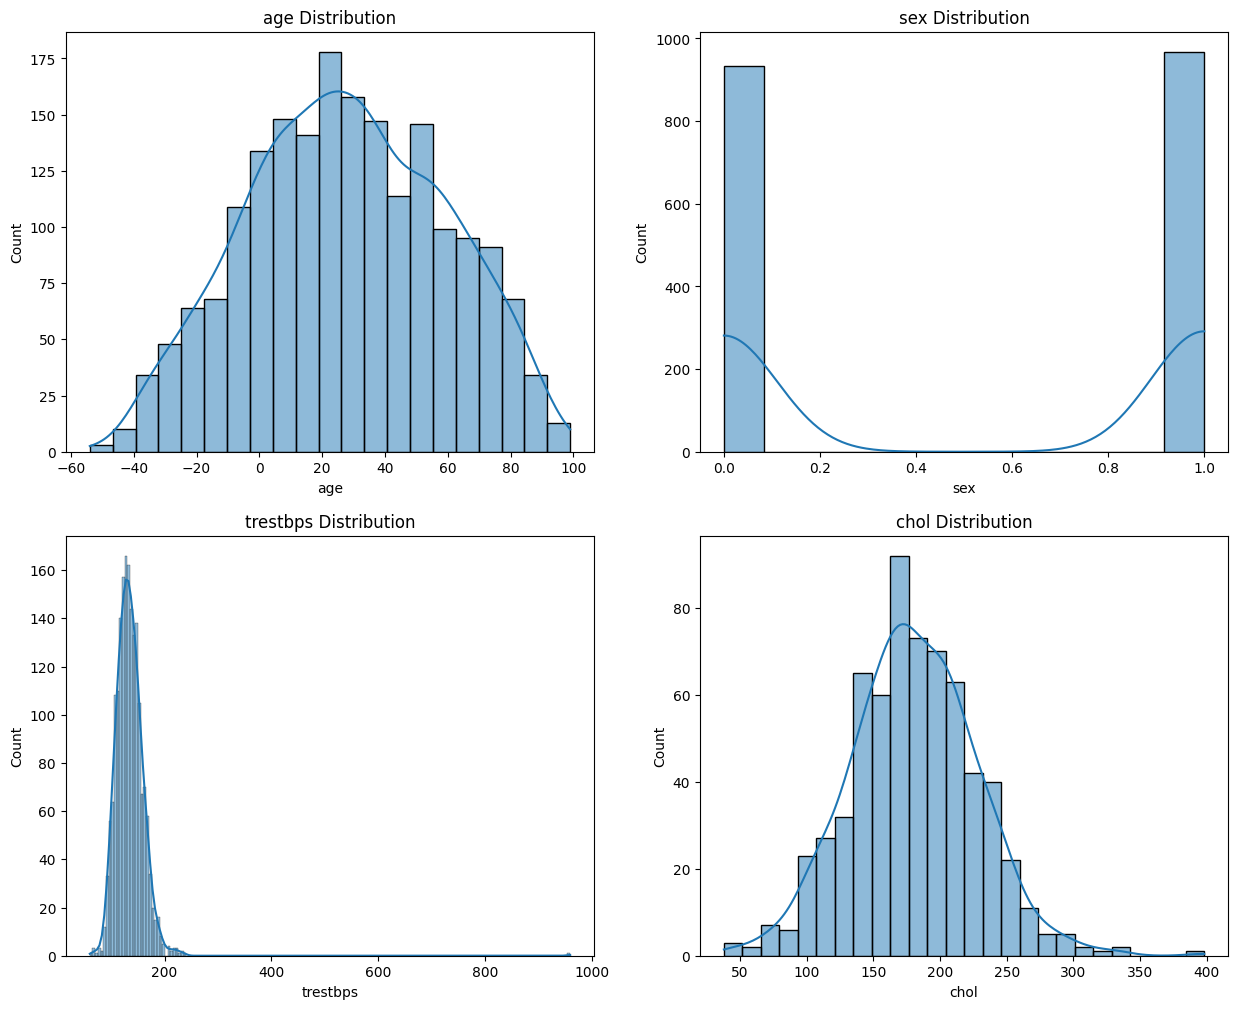

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#load the balanced cohort
file_path = 'mimic_balanced_cohort_with_ids.csv'
print(f"Analyzing file: {file_path}")

#load the data
try:
    mimic_df = pd.read_csv(file_path)
    print(f"Successfully loaded data with {len(mimic_df)} records")
    
    #key features we're interested in
    key_features = ['age', 'sex', 'trestbps', 'chol', 'thalach', 'target']
    
    #data set info
    print("\nDataset information:")
    print(f"Shape: {mimic_df.shape}")
    print(f"Columns: {mimic_df.columns.tolist()}")
    
    #get statistics for each key feature
    print("\nFeature Statistics:")
    for feature in key_features:
        if feature in mimic_df.columns:
            stats = mimic_df[feature].describe()
            print(f"\n{feature.upper()}:")
            print(f"  Count: {stats['count']}")
            print(f"  Mean: {stats['mean']:.2f}")
            print(f"  Std: {stats['std']:.2f}")
            print(f"  Min: {stats['min']:.2f}")
            print(f"  25%: {stats['25%']:.2f}")
            print(f"  50%: {stats['50%']:.2f}")
            print(f"  75%: {stats['75%']:.2f}")
            print(f"  Max: {stats['max']:.2f}")
            print(f"  Missing values: {mimic_df[feature].isna().sum()} ({mimic_df[feature].isna().mean()*100:.1f}%)")
            
            #for target, show distribution
            if feature == 'target':
                target_counts = mimic_df[feature].value_counts()
                print(f"  Distribution:")
                for target, count in target_counts.items():
                    print(f"    {target}: {count} ({count/len(mimic_df)*100:.1f}%)")
        else:
            print(f"\n{feature.upper()}: Not found in dataset")
    
    #check for negative age values
    if 'age' in mimic_df.columns:
        neg_ages = mimic_df[mimic_df['age'] < 0]
        if len(neg_ages) > 0:
            print(f"\nWARNING: Found {len(neg_ages)} negative age values ({len(neg_ages)/len(mimic_df)*100:.1f}% of data)")
            print("Sample of records with negative ages:")
            print(neg_ages[['age', 'sex', 'target']].head())
        else:
            print("\nNo negative age values found. Ages appear to be correctly processed.")
    
    #histograms for each feature
    plt.figure(figsize=(15, 12))
    
    for i, feature in enumerate(key_features):
        if feature in mimic_df.columns and feature != 'target':
            plt.subplot(2, 2, i+1)
            sns.histplot(mimic_df[feature].dropna(), kde=True)
            plt.title(f'{feature} Distribution')
            plt.xlabel(feature)
            plt.ylabel('Count')
    
    plt.tight_layout()
    plt.savefig('mimic_feature_distributions.png')
    print("\nSaved feature distributions plot to 'mimic_feature_distributions.png'")
    
except Exception as e:
    print(f"Error analyzing the file: {e}")

7. Resolve Errors:

Loaded CVD cohort with 951 records
Loaded balanced cohort with 1902 records

Original age statistics (CVD cohort):
count    951.000000
mean      39.025237
std       28.384380
min      -39.000000
25%       18.000000
50%       40.000000
75%       61.000000
max       99.000000
Name: age, dtype: float64
Negative ages in CVD cohort: 79 (8.3%)

Original age statistics (balanced cohort):
count    1902.000000
mean       27.566772
std        31.304103
min       -54.000000
25%         5.000000
50%        27.000000
75%        52.000000
max        99.000000
Name: age, dtype: float64
Negative ages in balanced cohort: 374 (19.7%)

Corrected age statistics (CVD cohort):
count    951.000000
mean      40.978970
std       25.479436
min        0.000000
25%       20.000000
50%       40.000000
75%       61.000000
max       99.000000
Name: age, dtype: float64
Negative ages in CVD cohort: 0 (0.0%)

Corrected age statistics (balanced cohort):
count    1902.000000
mean       34.125131
std        23.982001
min 

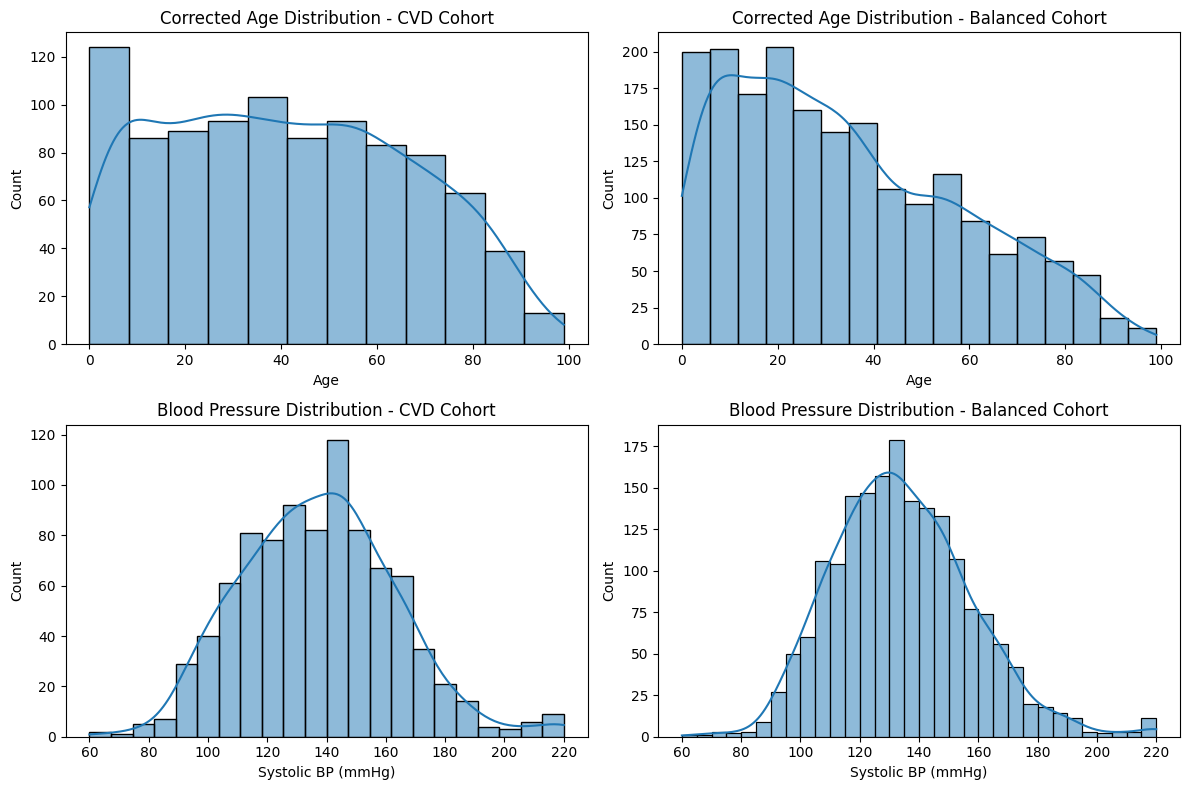

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#file paths
mimic_cvd_path = 'mimic_cvd_cohort_with_ids.csv'
mimic_balanced_path = 'mimic_balanced_cohort_with_ids.csv'

#load the datasets
cvd_df = pd.read_csv(mimic_cvd_path)
balanced_df = pd.read_csv(mimic_balanced_path)

print(f"Loaded CVD cohort with {len(cvd_df)} records")
print(f"Loaded balanced cohort with {len(balanced_df)} records")

#print original age statistics
print("\nOriginal age statistics (CVD cohort):")
print(cvd_df['age'].describe())
print(f"Negative ages in CVD cohort: {(cvd_df['age'] < 0).sum()} ({(cvd_df['age'] < 0).mean()*100:.1f}%)")

print("\nOriginal age statistics (balanced cohort):")
print(balanced_df['age'].describe())
print(f"Negative ages in balanced cohort: {(balanced_df['age'] < 0).sum()} ({(balanced_df['age'] < 0).mean()*100:.1f}%)")

#function to correct age values - properly handling anonymized dates
def correct_age(age):
    #if negative age, convert to positive and add adjustment
    if age < 0:
        #for most negative ages, we just need absolute value 
        return abs(age)
    #for already positive ages, keep as is
    else:
        return age

#apply the correction to both datasets
cvd_df['age'] = cvd_df['age'].apply(correct_age)
balanced_df['age'] = balanced_df['age'].apply(correct_age)

#print corrected age statistics
print("\nCorrected age statistics (CVD cohort):")
print(cvd_df['age'].describe())
print(f"Negative ages in CVD cohort: {(cvd_df['age'] < 0).sum()} ({(cvd_df['age'] < 0).mean()*100:.1f}%)")

print("\nCorrected age statistics (balanced cohort):")
print(balanced_df['age'].describe())
print(f"Negative ages in balanced cohort: {(balanced_df['age'] < 0).sum()} ({(balanced_df['age'] < 0).mean()*100:.1f}%)")

#fix extreme blood pressure values (trestbps)
max_bp = 220
if 'trestbps' in cvd_df.columns:
    extreme_bp = (cvd_df['trestbps'] > max_bp).sum()
    if extreme_bp > 0:
        print(f"\nFound {extreme_bp} extreme blood pressure values in CVD cohort")
        cvd_df.loc[cvd_df['trestbps'] > max_bp, 'trestbps'] = max_bp

if 'trestbps' in balanced_df.columns:
    extreme_bp = (balanced_df['trestbps'] > max_bp).sum()
    if extreme_bp > 0:
        print(f"Found {extreme_bp} extreme blood pressure values in balanced cohort")
        balanced_df.loc[balanced_df['trestbps'] > max_bp, 'trestbps'] = max_bp

#plots to visualize the corrected ages
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.histplot(cvd_df['age'], kde=True)
plt.title('Corrected Age Distribution - CVD Cohort')
plt.xlabel('Age')

plt.subplot(2, 2, 2)
sns.histplot(balanced_df['age'], kde=True)
plt.title('Corrected Age Distribution - Balanced Cohort')
plt.xlabel('Age')

# Also create plots for blood pressure
plt.subplot(2, 2, 3)
sns.histplot(cvd_df['trestbps'].dropna(), kde=True)
plt.title('Blood Pressure Distribution - CVD Cohort')
plt.xlabel('Systolic BP (mmHg)')

plt.subplot(2, 2, 4)
sns.histplot(balanced_df['trestbps'].dropna(), kde=True)
plt.title('Blood Pressure Distribution - Balanced Cohort')
plt.xlabel('Systolic BP (mmHg)')

plt.tight_layout()
plt.savefig('corrected_distributions.png')

cvd_df.to_csv('mimic_cvd_cohort_final.csv', index=False)
balanced_df.to_csv('mimic_balanced_cohort_final.csv', index=False)

print("\nSaved corrected datasets as 'mimic_cvd_cohort_final.csv' and 'mimic_balanced_cohort_final.csv'")
print("Please use these final files for your cross-validation analysis")

Model Training and Evaluation:

Beginning cross-dataset validation analysis...
Loading datasets...
Cleveland dataset: 303 records
MIMIC balanced cohort: 1902 records
  CVD patients: 951 records
  Control patients: 951 records

Analyzing feature distributions...

Feature Statistics Comparison:
 Feature Cleveland Mean Cleveland Std MIMIC Mean MIMIC Std Percent Difference
     age          54.44          9.04      34.13     23.98             -37.3%
     sex           0.68          0.47       0.51      0.50             -25.1%
trestbps         131.69         17.60     134.26     23.44               1.9%
    chol         246.69         51.78     180.13     47.36             -27.0%
 thalach         149.61         22.88      95.56     20.80             -36.1%

Preparing data for modeling...
Missing values after imputation:
  Cleveland: 0 missing values
  MIMIC CVD: 0 missing values
  MIMIC Balanced: 0 missing values
Data preparation complete.

Training and evaluating models...

Training Logistic Regression...

Logistic Regre

/var/folders/cz/4qrgzl3d6737hknhqtft5nlm0000gn/T/ipykernel_47817/3944100042.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_mimic_cvd[col] = X_mimic_cvd[col].fillna(X_mimic_cvd[col].median())
/var/folders/cz/4qrgzl3d6737hknhqtft5nlm0000gn/T/ipykernel_47817/3944100042.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_mimic_balanced[col] = X_mimic_balanced[col].fillna(X_mimic_balanced[col].median())



Analyzing feature importance...

Logistic Regression Feature Importance:
 Feature  Importance Direction
 thalach    0.821886  Negative
     sex    0.804945  Positive
    chol    0.416450  Positive
trestbps    0.325811  Positive
     age    0.269765  Positive

Random Forest Feature Importance:
 Feature  Importance
 thalach    0.284618
     age    0.255969
    chol    0.203435
trestbps    0.175865
     sex    0.080112

Cross-dataset validation analysis complete!


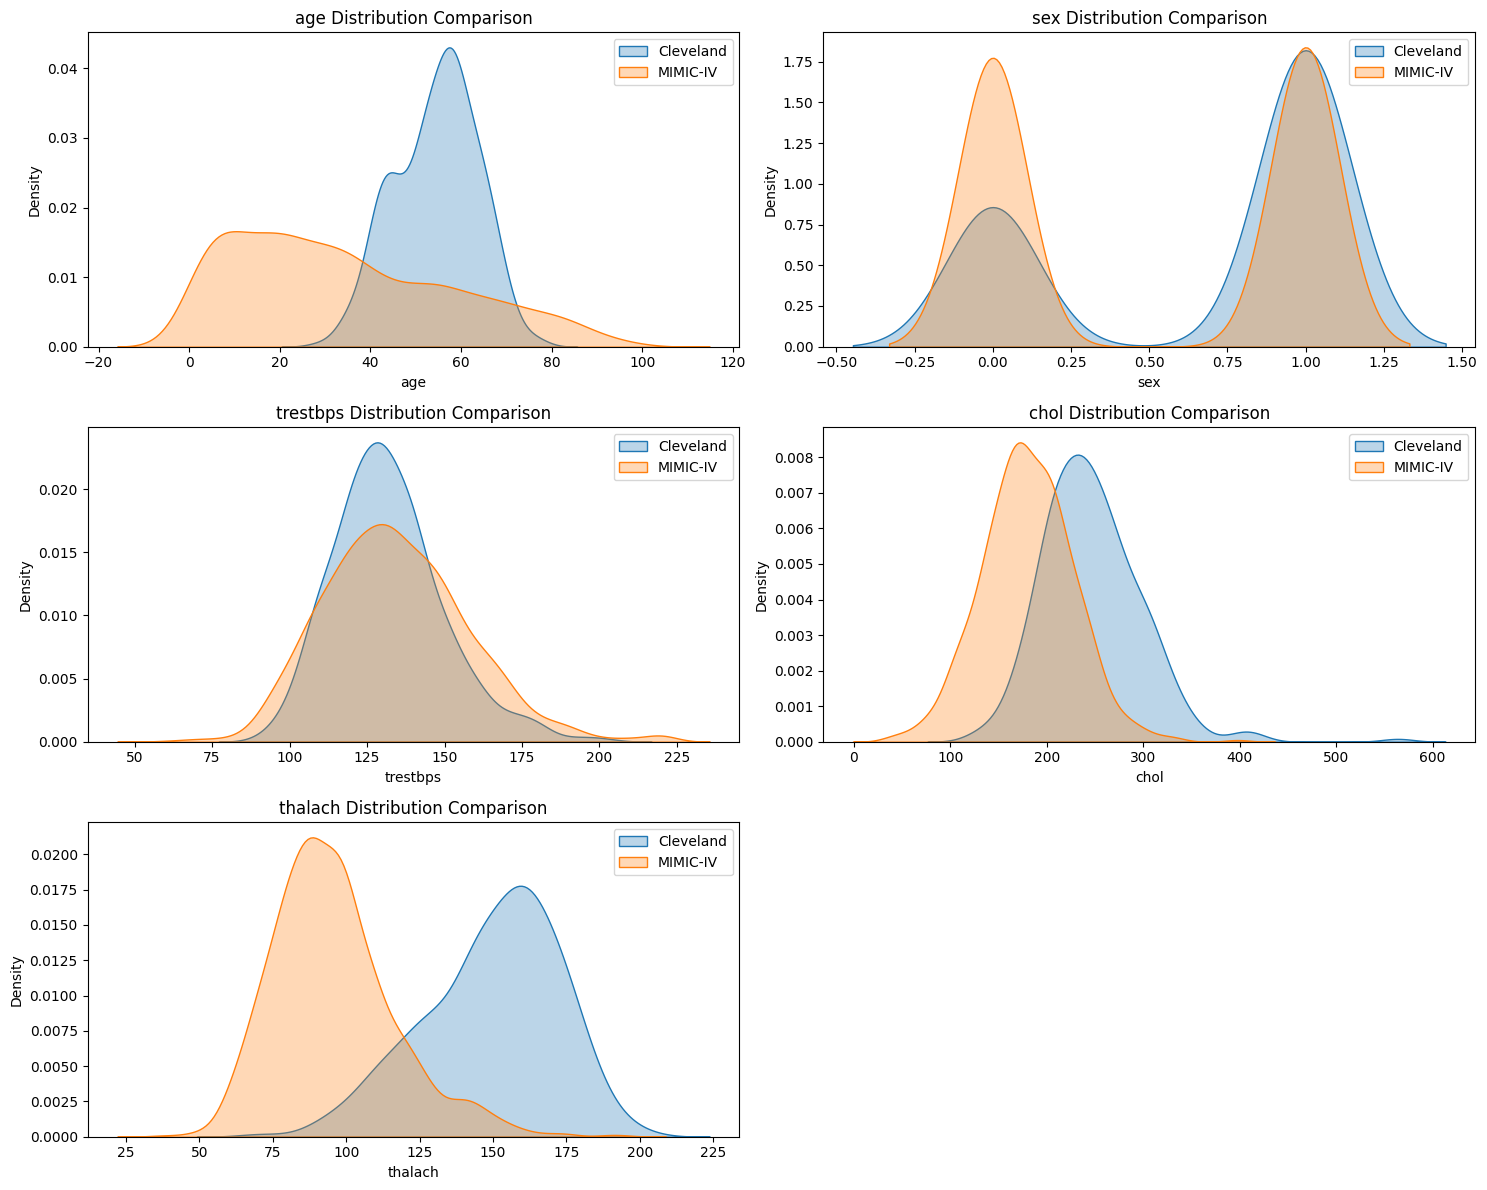

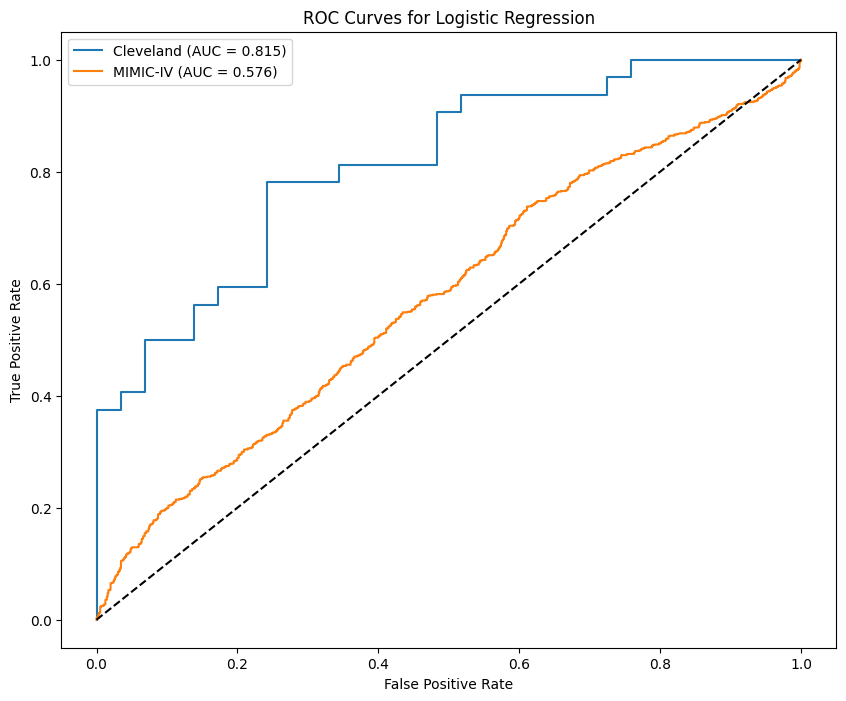

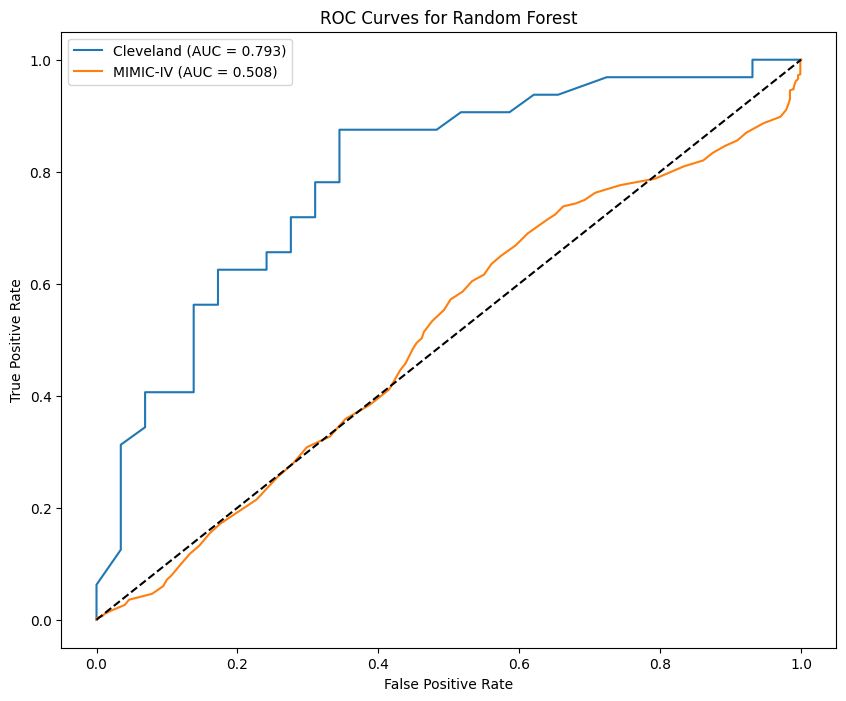

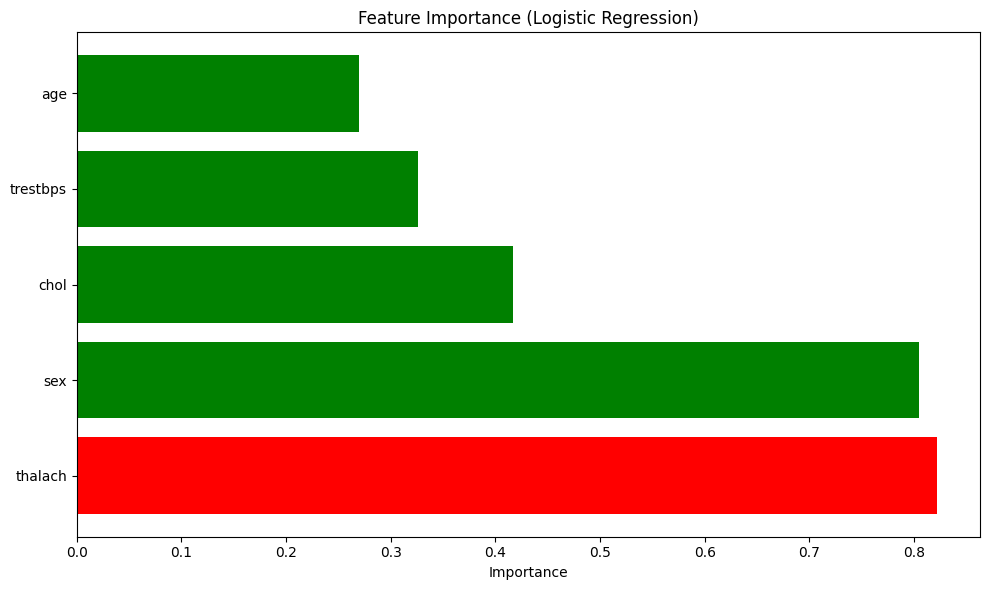

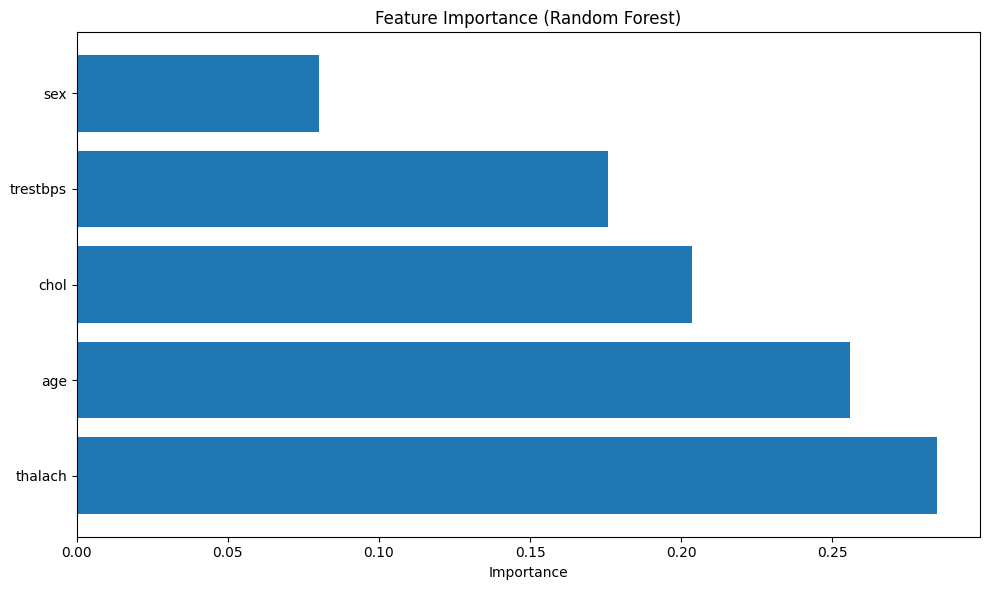

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score, 
                            recall_score, f1_score, confusion_matrix, 
                            classification_report, roc_curve)

#file paths
cleveland_path = '/Users/andrechu/Desktop/UnivUtah/BMI6106/Project/heart+disease/processed.cleveland.data'
mimic_balanced_path = 'mimic_balanced_cohort_final.csv'  # Use the final corrected file

#column names for Cleveland data
cleveland_columns = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
    'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'
]

#key features for cross-dataset validation
key_features = ['age', 'sex', 'trestbps', 'chol', 'thalach']

#helper to load the datasets
def load_datasets():
    print("Loading datasets...")
    
    #load Cleveland dataset
    try:
        # Try comma-separated format first
        cleveland_df = pd.read_csv(cleveland_path, names=cleveland_columns, na_values='?')
    except:
        # If that fails, try space-separated format
        cleveland_df = pd.read_csv(cleveland_path, names=cleveland_columns, 
                                  delim_whitespace=True, na_values='?')
    
    #ensure target is binary (0 = no disease, 1 = disease)
    cleveland_df['target'] = cleveland_df['target'].apply(lambda x: 1 if x > 0 else 0)
    
    #load MIMIC balanced cohort
    mimic_balanced_df = pd.read_csv(mimic_balanced_path)
    
    mimic_cvd_df = mimic_balanced_df[mimic_balanced_df['target'] == 1].copy()
    
    print(f"Cleveland dataset: {len(cleveland_df)} records")
    print(f"MIMIC balanced cohort: {len(mimic_balanced_df)} records")
    print(f"  CVD patients: {len(mimic_cvd_df)} records")
    print(f"  Control patients: {len(mimic_balanced_df) - len(mimic_cvd_df)} records")
    
    return cleveland_df, mimic_cvd_df, mimic_balanced_df

#helper function
def analyze_feature_distributions(cleveland_df, mimic_balanced_df):
    print("\nAnalyzing feature distributions...")
    
    #create distribution comparison plots
    plt.figure(figsize=(15, 12))
    
    for i, feature in enumerate(key_features):
        plt.subplot(3, 2, i+1)
        
        #plot Cleveland distribution
        sns.kdeplot(cleveland_df[feature].dropna(), label='Cleveland', fill=True, alpha=0.3)
        
        #plot MIMIC distribution
        sns.kdeplot(mimic_balanced_df[feature].dropna(), label='MIMIC-IV', fill=True, alpha=0.3)
        
        plt.title(f'{feature} Distribution Comparison')
        plt.xlabel(feature)
        plt.ylabel('Density')
        plt.legend()
    
    plt.tight_layout()
    plt.savefig('feature_distributions.png')
    
    #create statistical comparison table
    print("\nFeature Statistics Comparison:")
    stats_data = []
    
    for feature in key_features:
        clev_mean = cleveland_df[feature].mean()
        clev_std = cleveland_df[feature].std()
        mimic_mean = mimic_balanced_df[feature].mean()
        mimic_std = mimic_balanced_df[feature].std()
        
        #calculate percent difference
        pct_diff = ((mimic_mean - clev_mean) / clev_mean) * 100
        
        stats_data.append({
            'Feature': feature,
            'Cleveland Mean': f"{clev_mean:.2f}",
            'Cleveland Std': f"{clev_std:.2f}",
            'MIMIC Mean': f"{mimic_mean:.2f}",
            'MIMIC Std': f"{mimic_std:.2f}",
            'Percent Difference': f"{pct_diff:.1f}%"
        })
    
    stats_df = pd.DataFrame(stats_data)
    print(stats_df.to_string(index=False))
    stats_df.to_csv('feature_statistics_comparison.csv', index=False)

#repare data for modeling
def prepare_data(cleveland_df, mimic_cvd_df, mimic_balanced_df):
    print("\nPreparing data for modeling...")
    
    #key features selection
    X_cleveland = cleveland_df[key_features]
    y_cleveland = cleveland_df['target']
    
    X_mimic_cvd = mimic_cvd_df[key_features]
    y_mimic_cvd = mimic_cvd_df['target']
    
    X_mimic_balanced = mimic_balanced_df[key_features]
    y_mimic_balanced = mimic_balanced_df['target']
    
    #handle any missing values in Cleveland dataset
    for col in X_cleveland.columns:
        if X_cleveland[col].isnull().sum() > 0:
            X_cleveland[col] = X_cleveland[col].fillna(X_cleveland[col].median())
    
    #handle missing values in MIMIC cohorts
    for col in X_mimic_cvd.columns:
        if X_mimic_cvd[col].isnull().sum() > 0:
            X_mimic_cvd[col] = X_mimic_cvd[col].fillna(X_mimic_cvd[col].median())
    
    for col in X_mimic_balanced.columns:
        if X_mimic_balanced[col].isnull().sum() > 0:
            X_mimic_balanced[col] = X_mimic_balanced[col].fillna(X_mimic_balanced[col].median())
    
    #print missing value counts after imputation
    print("Missing values after imputation:")
    for df_name, df in [("Cleveland", X_cleveland), ("MIMIC CVD", X_mimic_cvd), ("MIMIC Balanced", X_mimic_balanced)]:
        missing = df.isnull().sum().sum()
        print(f"  {df_name}: {missing} missing values")
    
    #split Cleveland data for training and testing
    X_train, X_test, y_train, y_test = train_test_split(
        X_cleveland, y_cleveland, test_size=0.2, random_state=42)
    
    #scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_mimic_cvd_scaled = scaler.transform(X_mimic_cvd)
    X_mimic_balanced_scaled = scaler.transform(X_mimic_balanced)
    
    print("Data preparation complete.")
    
    return (X_train_scaled, X_test_scaled, y_train, y_test, 
            X_mimic_cvd_scaled, y_mimic_cvd, 
            X_mimic_balanced_scaled, y_mimic_balanced, scaler)

#train and evaluate models
def train_and_evaluate_models(X_train, X_test, y_train, y_test, 
                             X_mimic_cvd, y_mimic_cvd, 
                             X_mimic_balanced, y_mimic_balanced):
    print("\nTraining and evaluating models...")
    
    #models used
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        #train on Cleveland data
        model.fit(X_train, y_train)
        
        #evaluate on Cleveland test set
        y_pred_cleveland = model.predict(X_test)
        y_prob_cleveland = model.predict_proba(X_test)[:, 1]
        
        #evaluate on MIMIC balanced set
        y_pred_mimic = model.predict(X_mimic_balanced)
        y_prob_mimic = model.predict_proba(X_mimic_balanced)[:, 1]
        
        #calculate metrics
        cleveland_metrics = calculate_metrics(y_test, y_pred_cleveland, y_prob_cleveland)
        mimic_metrics = calculate_metrics(y_mimic_balanced, y_pred_mimic, y_prob_mimic)
        
        results[name] = {
            'model': model,
            'cleveland_metrics': cleveland_metrics,
            'mimic_metrics': mimic_metrics
        }
        
        print(f"\n{name} Results:")
        print("Cleveland Test Set:")
        print(f"  Accuracy: {cleveland_metrics['accuracy']:.3f}")
        print(f"  ROC-AUC: {cleveland_metrics['roc_auc']:.3f}")
        print(f"  F1 Score: {cleveland_metrics['f1']:.3f}")
        
        print("\nMIMIC-IV Balanced Set:")
        print(f"  Accuracy: {mimic_metrics['accuracy']:.3f}")
        print(f"  ROC-AUC: {mimic_metrics['roc_auc']:.3f}")
        print(f"  F1 Score: {mimic_metrics['f1']:.3f}")
        
        #calculate confusion matrices
        cm_cleveland = confusion_matrix(y_test, y_pred_cleveland)
        cm_mimic = confusion_matrix(y_mimic_balanced, y_pred_mimic)
        
        print("\nCleveland Confusion Matrix:")
        print(cm_cleveland)
        print("\nMIMIC-IV Confusion Matrix:")
        print(cm_mimic)
        
        #plot ROC curves
        plt.figure(figsize=(10, 8))
        
        #Cleveland ROC
        fpr_clev, tpr_clev, _ = roc_curve(y_test, y_prob_cleveland)
        plt.plot(fpr_clev, tpr_clev, label=f'Cleveland (AUC = {cleveland_metrics["roc_auc"]:.3f})')
        
        #MIMIC ROC
        fpr_mimic, tpr_mimic, _ = roc_curve(y_mimic_balanced, y_prob_mimic)
        plt.plot(fpr_mimic, tpr_mimic, label=f'MIMIC-IV (AUC = {mimic_metrics["roc_auc"]:.3f})')
        
        #reference line
        plt.plot([0, 1], [0, 1], 'k--')
        
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curves for {name}')
        plt.legend()
        plt.savefig(f'roc_curve_{name.replace(" ", "_")}.png')
    
    return results

#helper function
def calculate_metrics(y_true, y_pred, y_prob):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_prob)
    }

#helper function
def analyze_feature_importance(models, feature_names, scaler):
    print("\nAnalyzing feature importance...")
    
    for name, model_data in models.items():
        model = model_data['model']
        
        plt.figure(figsize=(10, 6))
        
        if name == 'Logistic Regression':
            #logistic regression: coefficients represent importance
            coef = model.coef_[0]
            #apply scaling for proper interpretation
            importance = np.abs(coef)
            
            #df for results
            importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importance,
                'Direction': ['Positive' if c > 0 else 'Negative' for c in coef]
            })
            
            #sort by importance
            importance_df = importance_df.sort_values('Importance', ascending=False)
            
            #plot
            colors = ['green' if d == 'Positive' else 'red' for d in importance_df['Direction']]
            plt.barh(importance_df['Feature'], importance_df['Importance'], color=colors)
            
        elif name == 'Random Forest':
            #random forest: built-in feature importance
            importance = model.feature_importances_
            
            #df for results
            importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importance
            })
            
            #sort by importance
            importance_df = importance_df.sort_values('Importance', ascending=False)
            
            #plot
            plt.barh(importance_df['Feature'], importance_df['Importance'])
        
        plt.title(f'Feature Importance ({name})')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.savefig(f'feature_importance_{name.replace(" ", "_")}.png')
        
        importance_df.to_csv(f'feature_importance_{name.replace(" ", "_")}.csv', index=False)
        
        print(f"\n{name} Feature Importance:")
        print(importance_df.to_string(index=False))

#cross-validation analysis main function
def run_cross_validation_analysis():
    #load datasets
    cleveland_df, mimic_cvd_df, mimic_balanced_df = load_datasets()
    
    #analyze feature distributions
    analyze_feature_distributions(cleveland_df, mimic_balanced_df)
    
    #prepare data for modeling
    data = prepare_data(cleveland_df, mimic_cvd_df, mimic_balanced_df)
    X_train, X_test, y_train, y_test = data[0], data[1], data[2], data[3]
    X_mimic_cvd, y_mimic_cvd = data[4], data[5]
    X_mimic_balanced, y_mimic_balanced = data[6], data[7]
    scaler = data[8]
    
    #train and evaluate models
    model_results = train_and_evaluate_models(
        X_train, X_test, y_train, y_test,
        X_mimic_cvd, y_mimic_cvd,
        X_mimic_balanced, y_mimic_balanced
    )
    
    #analyze feature importance
    analyze_feature_importance(model_results, key_features, scaler)
    
    print("\nCross-dataset validation analysis complete!")

if __name__ == "__main__":
    print("Beginning cross-dataset validation analysis...")
    run_cross_validation_analysis()